#### Import Packages

In [100]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import imblearn
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,roc_auc_score,roc_curve
import statsmodels.api as sm
import keras_tuner as kt
import seaborn as sns

# Question 1
### Question
Briefly discuss why it is more difficult to find a good classifier on such a dataset than on one where, for example, 5,000 claims are fraudulent, and 5,000 are not. In particular, consider what happens when undetected fraudulent claims are very costly to the insurance company.

### Answer
When the dataset in highly unbalanced, like what in the car-insurance case, the machine learning algorithm can predict well in the majority class and predict poorly in minority class. Since most of machine learning algorithm always pursue to decrease error rate, thus they tend to predict the all the label to majority class one. In our scenario, the algorithm tends to predict all the claims non-fraudulent. However, the wrong prediction will increase the False-negative rate, which will increase the cost of fraudulent claims.
Another issue related to the scarce minority data is that we might miss some key combination of variables that has high probability to be fraudulent.

Check how much NaN values in each column when the claim is frandulent.
We can find when the claim is frandulent, most of the numerical variables are not missing, which means we could directly drop them.

In [101]:
# check the range of all variables and drop unreasonable numbers
# split first and scale with smote code
# check scale first or smote first
# validation loss and trainning loss
# the batch size is 32
# TODO train test validation
# check the roc curve
# hidden layer number
# claim involved cover
# TODO clear session andv set seeds #FIXME
# TODO sensebility_at_spec
# TODO set seeds before 
# TODO model summary
# TODO save model 

# TO ASK
# How to select the best model?

# Question 2

### TODO    
calculate the number of policyholdersnumber and vehicle number

### Question
Load the dataset "Insurance_claims.csv" and clean it as appropriate for use with machine learning algorithms. A description of the features can be found at the end of this document.

### Principle
1. Since the dataset is highly unbalanced, and the fraudulent dataset is very scarce, we don't want to drop the data label with 'fradulent'.
2. When the variables is categorical varibles, we tend to keep the Nah value as a classificaiton value rather than drop it.
3. When the variables is numerical variables, we will check how many NaN values is related to the fraudulent case. If few of them, we will drop the variable. Otherwise, we will find a way to fill in the NaN values.

### Proprocess procedure
1. load data and select useful columns
2. drop duplicates
3. drop unreasonable rows
4. deal with nan data
    - deal with the categorical nan data
    - deal with the numerical nan data
5. deal with date data
6. get an insight of the distribution of dataset
    - check whether there is a signicicant distribution difference in every column in fraud data and non-fraud data
7. clean features
    - dummy
      - PolicyholderOccupation
      - ClaimCause
      - ClaimInvolvedCovers
      - DamageImportance
      - FirstPartyVehicleType 
      - ConnectionBetweenParties
      - PolicyWasSubscribedOnInternet
    - extract features in 'ClaimInvolvedCovers'
    - outlier # TODO
8. split data and scale
9.  show the data structure after preprocess



## 2.1 Load data and select useful columns
We are going to use the following features to predict the fraud cases:
1. PolicyholderOccupation
2. LossDate
3. FirstPolicySubscriptionDate
4. ClainType
5. ClaimInvolvedCovers
6. DamageImportance
7. FirstPartyVehicleType
8. ConnectionBetweenParties
9. PolicyWasSubscribedOnInternet
10. NumberOfPoliciesOfPolicyholder
11. FpVehicleAgeMonths
12. EasinessToStage
13. ClaimWihoutIdentifiedThirdParty
14. ClaimAmount
15. LossHour
16. PolicyHolderAge
17. NumberOfBodilyInjuries
18. FirstPartyLiability
19. LossAndHolderPostCodeSame

And we also need label:
1. Fraud

In [102]:
# read data and get a brief idea of the data
df = pd.read_csv('./materials/Insurance_claims.csv')
# get useful features that needed in the machine learning model
# TODO using nlp to insurer notes data
needed_columns = [ 'PolicyholderOccupation',
       'LossDate', 'FirstPolicySubscriptionDate', 'ClaimCause',
       'ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType',
       'ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet',
       'NumberOfPoliciesOfPolicyholder', 'FpVehicleAgeMonths',
       'EasinessToStage', 'ClaimWihoutIdentifiedThirdParty', 'ClaimAmount',
       'LossHour', 'PolicyHolderAge', 'NumberOfBodilyInjuries',
       'FirstPartyLiability', 'LossAndHolderPostCodeSame','Fraud']
df = df[needed_columns]

# show the first 5 rows, get some idea of the data structure
print(f'Data sample:')
print(df.head(5)) #TODO use sentiment analysis 
print('-----------------------------------------------------')

# get the columns name
print('Data Columns:')
print(str(df.columns))
print('-----------------------------------------------------')

# get some basic information about the data, and we found that the min number 
# of FpVehicleAgeMonths is less than 0, which does't make sense. We are going 
# to detect whether these rows are fraud cases or not. If they are all non-fraud,
# we can drop the rows with negative FpVehicleAgeMonths value. Otherwise, we will 
# create a new feature that record these abnormal rows since these unreasonable 
# values might be evidence of fraud cases.
print('Data description:')
print(df.describe())
print('-----------------------------------------------------')

# check whether there are any duplicated rows and we found there are 8 duplicated rows,
# which we are going to drop.
print('Data duplicated rows:')
print(df.duplicated().sum())
print('-----------------------------------------------------')

Data sample:
  PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
0           CivilServant  02.01.19                    18.06.18   
1                 Worker  02.01.19                    29.06.17   
2                 Worker  02.01.19                    05.02.17   
3           CivilServant  02.01.19                    21.01.17   
4                 Farmer  02.01.19                    13.01.18   

                         ClaimCause  \
0               CollisionWithAnimal   
1                     LossOfControl   
2  AccidentWithIdentifiedThirdParty   
3  AccidentWithIdentifiedThirdParty   
4  AccidentWithIdentifiedThirdParty   

                               ClaimInvolvedCovers DamageImportance  \
0                     MaterialDamages ActLiability              NaN   
1                     MaterialDamages ActLiability              NaN   
2                     MaterialDamages ActLiability              NaN   
3  MaterialDamages ActLiability ReplacementVehicle              NaN   


## 2.2 Drop the duplicated rows

In [103]:
print('The shape of the data before dropping duplicated rows:')
df_shape_before_drop = df.shape
print(df.shape)
print('-----------------------------------------------------')

# drop the duplicated rows
df.drop_duplicates(inplace=True)

print('The shape of the data after dropping duplicated rows:')
df_shape_after_drop = df.shape
print(df.shape)
print('-----------------------------------------------------')

print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')

The shape of the data before dropping duplicated rows:
(11530, 20)
-----------------------------------------------------
The shape of the data after dropping duplicated rows:
(11516, 20)
-----------------------------------------------------
The number of rows that are dropped: 14


## 2.3 Drop unreasonable values


In [104]:
# check whether unreasonable rows contain fraud cases
df_unreasonable_rows = df[df['FpVehicleAgeMonths'] < 0]
df_shape_before_drop = df_unreasonable_rows.shape
print(df_unreasonable_rows)
print('-----------------------------------------------------')
# we can find that these three rows are not fraud cases. 
# Since we have enough non-fraud data, we can drop these rows.
df_shape_before_drop = df.shape
df.drop(df_unreasonable_rows.index, inplace=True)
df_shape_after_drop = df.shape

print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')

     PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
8019                Retired  24.06.20                    22.10.19   
8446                Retired  21.07.20                    26.02.20   
8529                Retired  17.07.20                    26.02.20   

            ClaimCause           ClaimInvolvedCovers DamageImportance  \
8019     LossOfControl  MaterialDamages ActLiability              NaN   
8446     LossOfControl  MaterialDamages ActLiability              NaN   
8529  WindscreenDamage                    Windscreen              NaN   

     FirstPartyVehicleType ConnectionBetweenParties  \
8019                   Car                      NaN   
8446                   Car                      NaN   
8529                   Car                      NaN   

      PolicyWasSubscribedOnInternet  NumberOfPoliciesOfPolicyholder  \
8019                              0                               2   
8446                              0                               4

## 2.4 Deal with NaN data
Check how much NaN values in each column.

We can find that except for 'FirstPartyVehicleNumber', 'ThirdPartyVehicleNumber', 'InsurerNotes', which we might not use in our models, most the NaN values are concentrated in the 'PolicyholderOccupation', 'ClaimCause',etc which are mainly categorical variables. In this case, we could turn these NaN values into a category value in order to take account the influence of missing variables, no mather what reason they are missing.

In terms of the numeric variables, we will furtherly check how many of them are missing when the claim is fraudulent or not. 

In [105]:
# Check how much NaN values in each column.
print(f'Number of NaN values in each column:') 
print(df.isnull().sum())

Number of NaN values in each column:
PolicyholderOccupation               340
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           191
ClaimInvolvedCovers                  189
DamageImportance                   10775
FirstPartyVehicleType                 12
ConnectionBetweenParties           11415
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    12
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              94
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
LossAndHolderPostCodeSame              0
Fraud                                  0
dtype: int64


We can find that in the Fraud case, there are a lot of data missing in categorical columns, but few in numerical columns.

Thus, we can set NaN as a category of categorical data and generate dummy variables. And we can drop the rows that contains NaN values in numerical columns.

In [106]:
# Check the number of missing data when Frand is True
df_fraud = df[df["Fraud"]==1]
print(f'Number of NaN values in each column when Frand is True:') 
print(df_fraud.isnull().sum())

Number of NaN values in each column when Frand is True:
PolicyholderOccupation               4
LossDate                             0
FirstPolicySubscriptionDate          0
ClaimCause                           0
ClaimInvolvedCovers                  0
DamageImportance                    96
FirstPartyVehicleType                2
ConnectionBetweenParties           102
PolicyWasSubscribedOnInternet        0
NumberOfPoliciesOfPolicyholder       0
FpVehicleAgeMonths                   2
EasinessToStage                      0
ClaimWihoutIdentifiedThirdParty      0
ClaimAmount                          0
LossHour                             1
PolicyHolderAge                      0
NumberOfBodilyInjuries               0
FirstPartyLiability                  0
LossAndHolderPostCodeSame            0
Fraud                                0
dtype: int64


In [107]:
df_non_frand = df[df["Fraud"]==0]
print(f'Number of NaN values in each column when Frand is False:')
print(df_non_frand.isnull().sum())

Number of NaN values in each column when Frand is False:
PolicyholderOccupation               336
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           191
ClaimInvolvedCovers                  189
DamageImportance                   10679
FirstPartyVehicleType                 10
ConnectionBetweenParties           11313
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    10
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              93
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
LossAndHolderPostCodeSame              0
Fraud                                  0
dtype: int64


Fill the missing data in categorical columns with string NaN and make it a category

In [108]:
dummy_columns = ['PolicyholderOccupation', 'ClaimCause','ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']
df[dummy_columns] = df[dummy_columns].fillna('NaN')

Drop the missing data in numerical columns

In [109]:
df_shape_before_drop = df.shape
df_fraud_shape_before_drop = df[df["Fraud"]==1].shape
df.dropna(subset=["LossHour","PolicyHolderAge","FpVehicleAgeMonths"],inplace=True)
df_shape_after_drop = df.shape
df_fraud_shape_after_drop = df[df["Fraud"]==1].shape
print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')
print(f'The number of rows that are dropped when Frand is True: {df_fraud_shape_before_drop[0]-df_fraud_shape_after_drop[0]}')

The number of rows that are dropped: 142
The number of rows that are dropped when Frand is True: 3


After these steps, we don't have any missing data.

In [110]:
print('The number of NaN values in each column:')
df.isna().sum()
print('-----------------------------------------------------')

print('The shape of final datasets:')
print(df.shape)
print('-----------------------------------------------------')

print("Data sample:")
print(df.head(5))
print('-----------------------------------------------------')

The number of NaN values in each column:
-----------------------------------------------------
The shape of final datasets:
(11371, 20)
-----------------------------------------------------
Data sample:
  PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
0           CivilServant  02.01.19                    18.06.18   
1                 Worker  02.01.19                    29.06.17   
2                 Worker  02.01.19                    05.02.17   
3           CivilServant  02.01.19                    21.01.17   
4                 Farmer  02.01.19                    13.01.18   

                         ClaimCause  \
0               CollisionWithAnimal   
1                     LossOfControl   
2  AccidentWithIdentifiedThirdParty   
3  AccidentWithIdentifiedThirdParty   
4  AccidentWithIdentifiedThirdParty   

                               ClaimInvolvedCovers DamageImportance  \
0                     MaterialDamages ActLiability              NaN   
1                     M

## 2.5 Deal with date data
We tend to consider the date data as important features. Because we consider that in different time period, people might have different tendency to defraud. And this argument is supported by Pascal Blanque(2002), who asserted that the economic crisis is an important reason for the defraud.

However, our date data is datetime format, which cannot be used in machine learning model. In hence, we will convert the date data into timestamp.

In [111]:
# turn the date into timestamp
df['LossDate'] = df['LossDate'].apply(lambda x:datetime.datetime.strptime(x,'%d.%M.%y').timestamp())
df['FirstPolicySubscriptionDate'] = df['FirstPolicySubscriptionDate'].apply(lambda x:datetime.datetime.strptime(x,'%d.%M.%y').timestamp())

## 2.6 Get an insight of the distribution of dataset

According to the distribution of the numerical data, we can see that there are some diffenece between the fraud and non-fraud cases, especially in the distribution of 'FpVehicleAgeMonths' and 'claimAmount'. In the fraud cases, they usually have a more disperse distribution in 'FpVehicleAgeMonths' and higher value in 'claimAmount'. 

And in the categorical data, we can find some interesting patterns. For example, in the fraud cases, the percentage of 'TotalLoss' is much higher than the non-fraud cases, which is understandable. And in the fraud cases, the fraud cases tend to be same address between two parties.

In [112]:
# get the datasets that are fraud cases and non-fraud cases
df_fraud = df[df['Fraud'] == 1]
df_non_fraud = df[df['Fraud'] == 0]

# get the mean of both datasets
print('The mean of fraud datasets:')
print('-----------------------------------------------------')
df_fraud_mean = df_fraud.mean()
print(df_fraud_mean)
print('-----------------------------------------------------')

print('The mean of non-fraud datasets:')
print('-----------------------------------------------------')
df_non_fraud_mean = df_non_fraud.mean()
print(df_non_fraud_mean)
print('-----------------------------------------------------')

The mean of fraud datasets:
-----------------------------------------------------
LossDate                           1.557971e+09
FirstPolicySubscriptionDate        1.546519e+09
PolicyWasSubscribedOnInternet      2.857143e-01
NumberOfPoliciesOfPolicyholder     1.625000e+00
FpVehicleAgeMonths                 1.177143e+02
EasinessToStage                    3.464286e-01
ClaimWihoutIdentifiedThirdParty    5.625000e-01
ClaimAmount                        3.647878e+03
LossHour                           1.292857e+01
PolicyHolderAge                    4.104464e+01
NumberOfBodilyInjuries             3.571429e-02
FirstPartyLiability                4.910714e-01
LossAndHolderPostCodeSame          6.160714e-01
Fraud                              1.000000e+00
dtype: float64
-----------------------------------------------------
The mean of non-fraud datasets:
-----------------------------------------------------
LossDate                           1.564733e+09
FirstPolicySubscriptionDate        1.523620

/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_63917/3244136970.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fraud_mean = df_fraud.mean()
/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_63917/3244136970.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_non_fraud_mean = df_non_fraud.mean()


The distribution numerical data of fraud datasets:


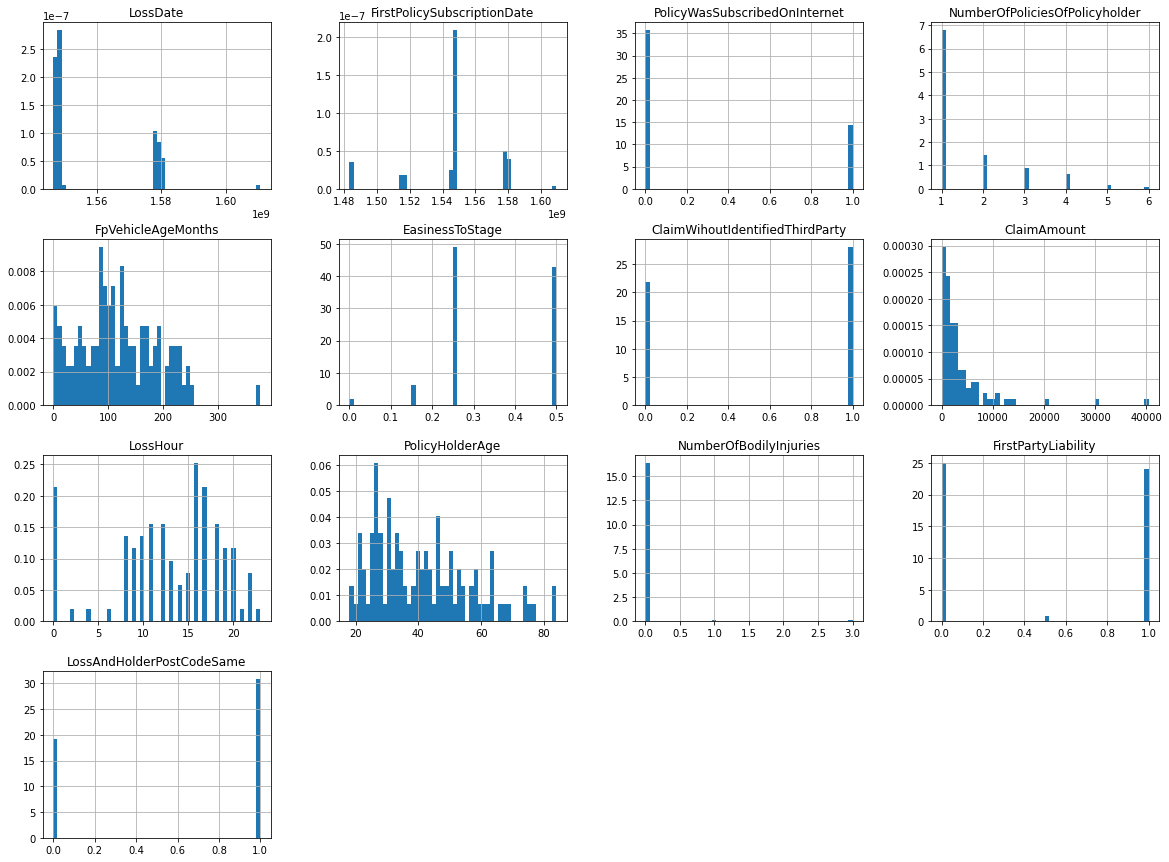

-----------------------------------------------------
The distribution numerical data of non-fraud datasets:


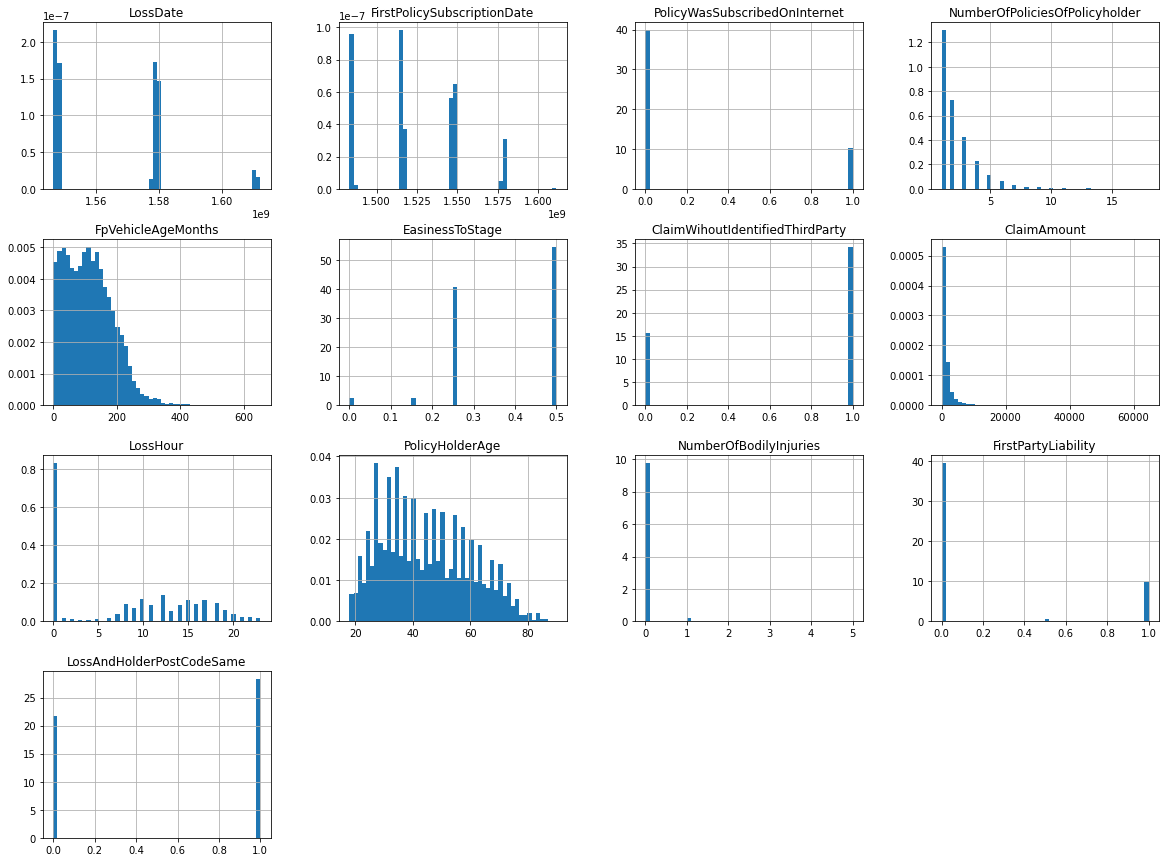

In [113]:
# plot the distribution of fraud datasets
print('The distribution numerical data of fraud datasets:')
df_fraud.iloc[:,:-1].hist(bins=50, figsize=(20,15),density=True, xlabelsize=10, ylabelsize=10) #TODO add title
plt.show()
print('-----------------------------------------------------')

# plot the distribution of non-fraud datasets
print('The distribution numerical data of non-fraud datasets:')
df_non_fraud.iloc[:,:-1].hist(bins=50, figsize=(20,15),density=True, xlabelsize=10, ylabelsize=10)
plt.show()

# TODO show the classification of categorical data

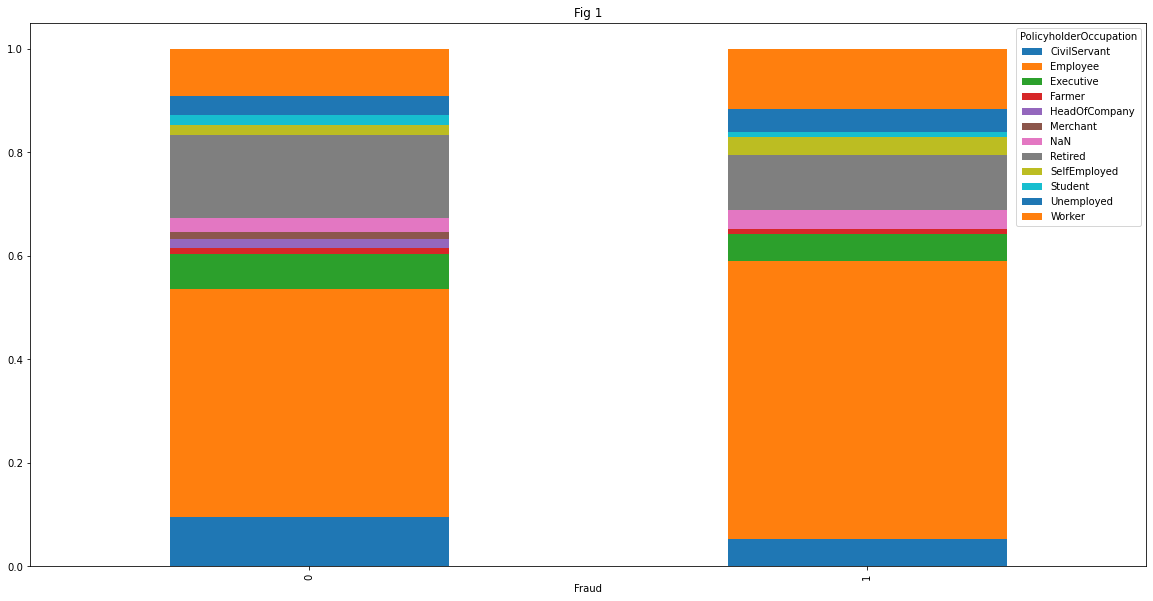

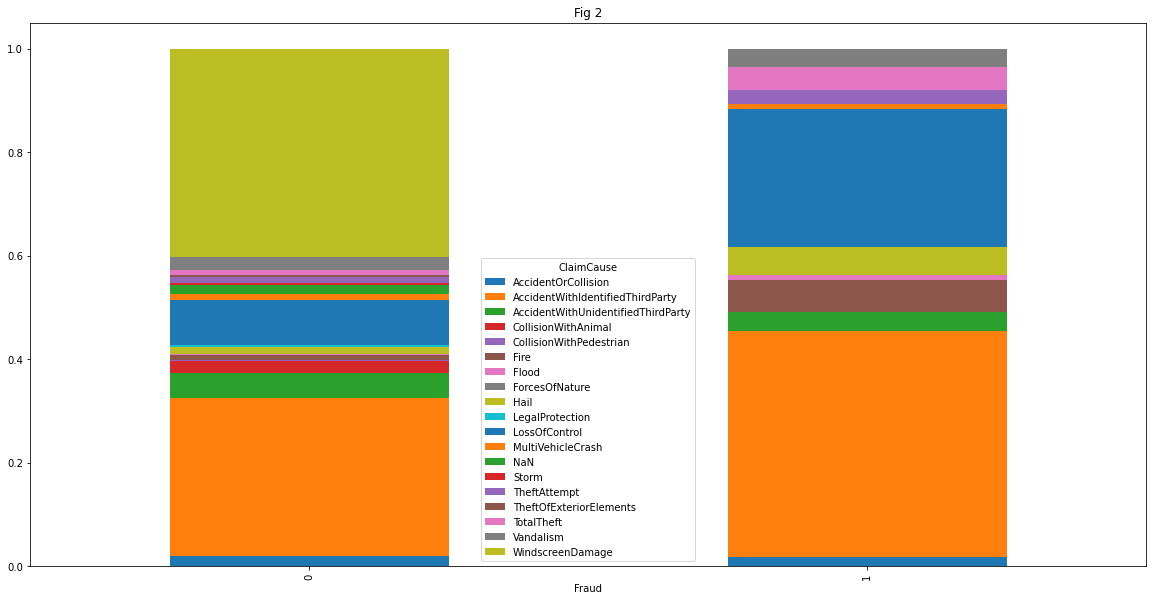

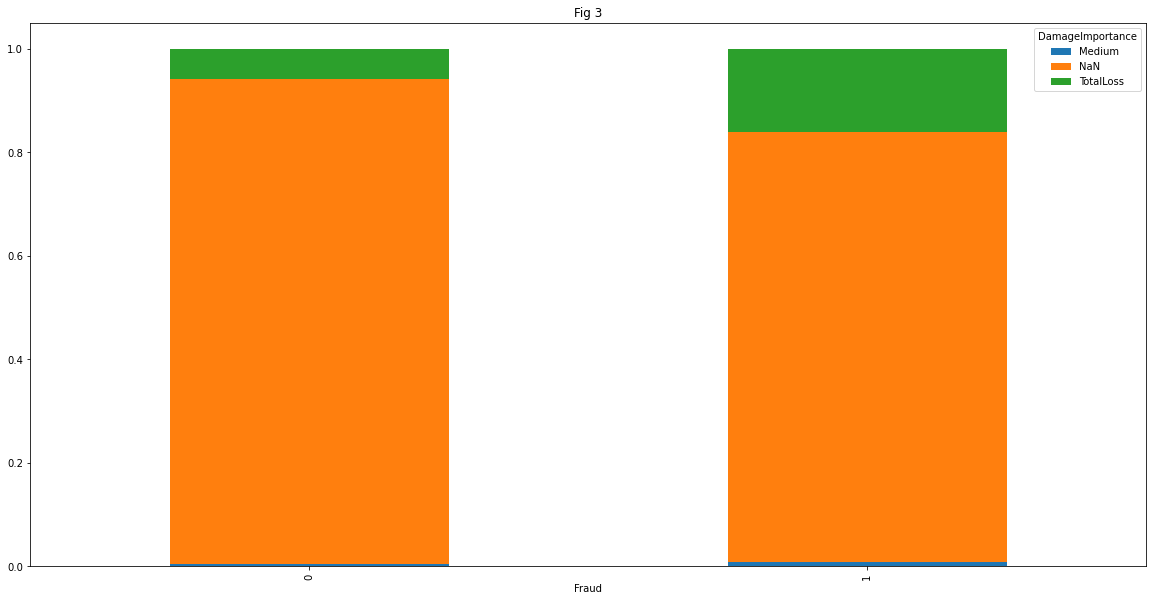

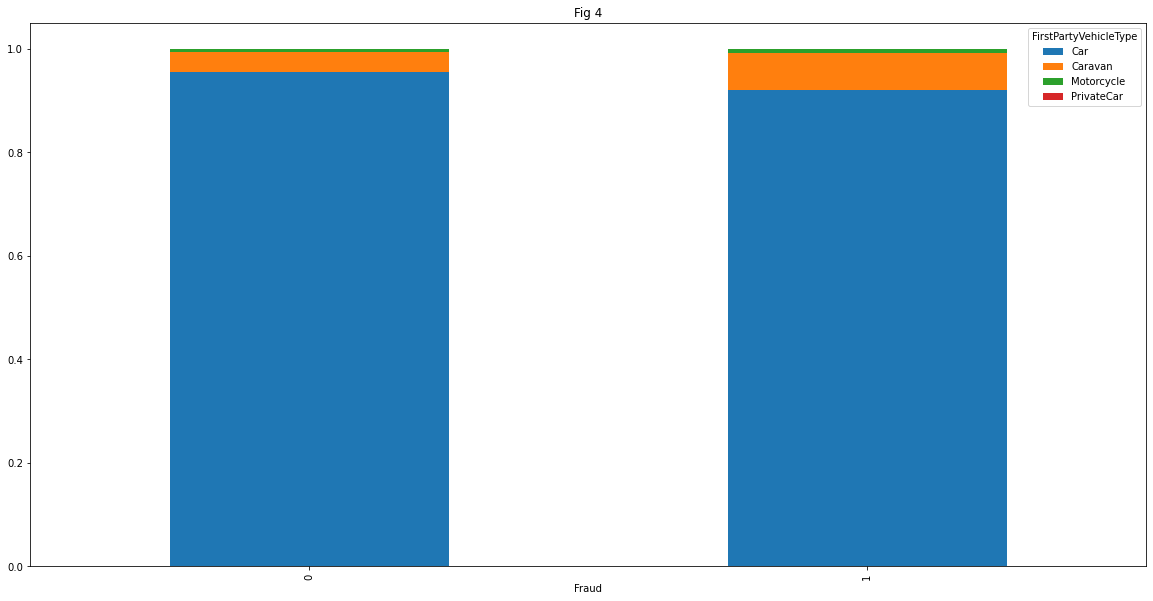

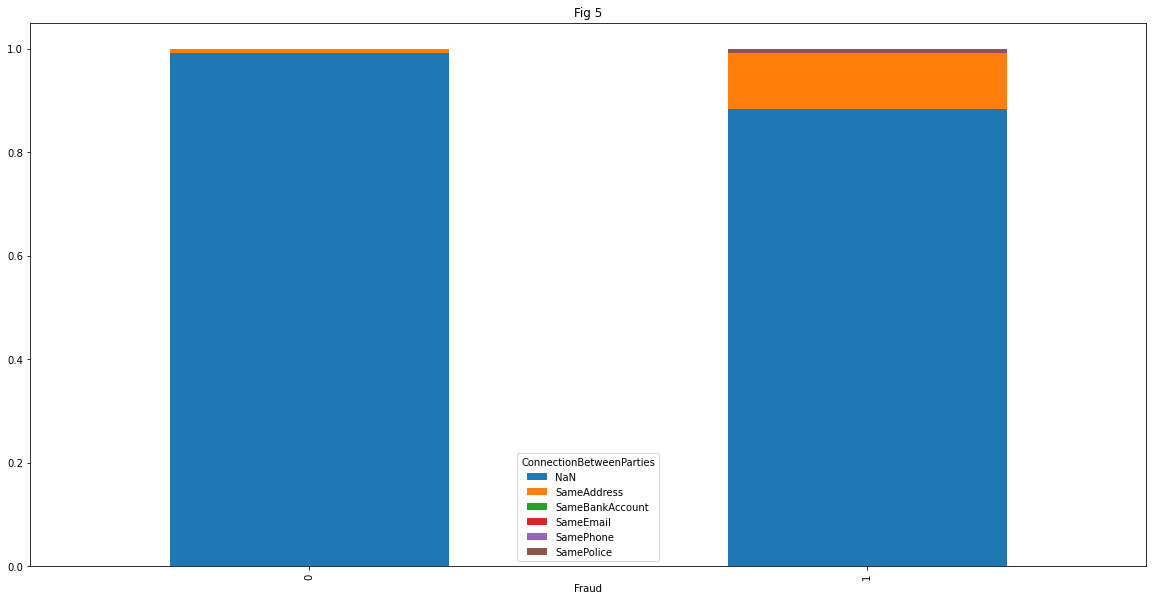

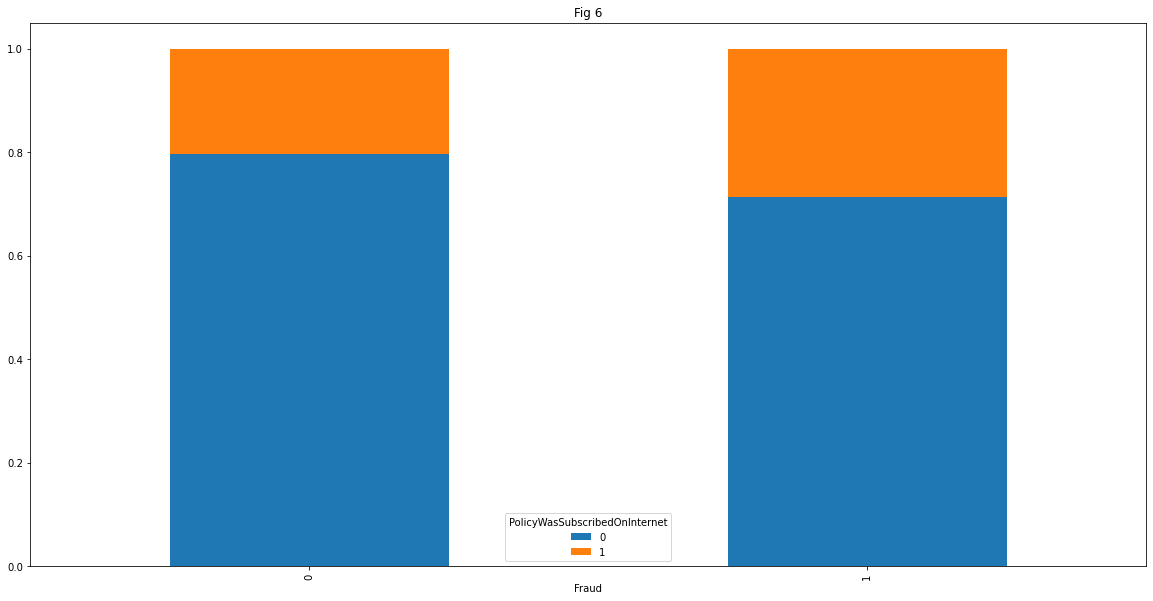

In [114]:
dummy_columns = ['PolicyholderOccupation', 'ClaimCause', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']

names = locals()
for i, col in enumerate(dummy_columns):
    names[f"ax_{i}"] = df.groupby(['Fraud'])[col].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(20,10),title=f"Fig {i+1}")

## 2.7 Clean features
1. deal with outliers 
    The presence of outliers in the data is a major problem for machine learning algorithms (Chakravarty, et al., 2020). 
    TODO: deal with outliers, or at the end to illustrate the lackness of the research
   
     
2. dummy variables

In [115]:
# Get dummy variables for categorical data
dummy_columns = ['PolicyholderOccupation', 'ClaimCause', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']
# Dummy variables for categorical data
df = pd.get_dummies(df,columns=dummy_columns,drop_first=True)
df.head()

,LossDate,FirstPolicySubscriptionDate,ClaimInvolvedCovers,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,...,DamageImportance_TotalLoss,FirstPartyVehicleType_Caravan,FirstPartyVehicleType_Motorcycle,FirstPartyVehicleType_PrivateCar,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,PolicyWasSubscribedOnInternet_1
0,1.546387e+09,1.516234e+09,MaterialDamages ActLiability,1,104.0,0.25,1,4624.73,8.0,45.0,...,0,0,0,0,0,0,0,0,0,1
1,1.546387e+09,1.485648e+09,MaterialDamages ActLiability,3,230.0,0.50,1,1606.81,11.0,20.0,...,0,0,0,0,0,0,0,0,0,0
2,1.546387e+09,1.483575e+09,MaterialDamages ActLiability,9,93.0,0.25,0,998.20,18.0,32.0,...,0,0,0,0,0,0,0,0,0,0
3,1.546387e+09,1.484957e+09,MaterialDamages ActLiability ReplacementVehicle,2,56.0,0.25,0,2506.92,11.0,46.0,...,0,0,0,0,0,0,0,0,0,0
4,1.546387e+09,1.515802e+09,ActLiability,4,110.0,0.25,0,12.00,12.0,28.0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# Extract ClaimInvolvedCovers data
# Get all covers
all_unique =  df["ClaimInvolvedCovers"].unique().tolist()
all_covers = str.join(' ', all_unique) # join the string to list
all_covers_set = set(all_covers.split()) # use set to drop duplicate covers
print(all_covers_set)

for cover in all_covers_set:
    df[f"ClaimInvolvedCovers_{cover}"] = df["ClaimInvolvedCovers"].apply(lambda x: 1 if cover in x else 0)
df = df.drop(columns=['ClaimInvolvedCovers'])

{'ReplacementVehicle', 'ActLiability', 'MaterialDamages', 'Theft', 'Burglary', 'Accessories', 'MedicalCare', 'NaN', 'Fire', 'NaturalCatastrophes', 'ThirdPartyMaterialDamages', 'Windscreen', 'ThirdParty'}


## 2.8 Split the data and scale
We are going to use MinMaxScaler in this case, since we can find the dataset not follow a Gaussian distribution. In addition, we will fit the MinMaxScaler model with trainning and validation dataset and apply the model to the test dataset to ensure we are blind to the data information before we test the data.
Here is the process of split and scale data:
1. Turn the dataframe into X and y array
1. Split the train and test
2. Fit the MinMaxScaler to train data and then apply the model to test data
3. Split the train data into train and validation data

In [117]:
# Turn the dataframe into X and y array
X = df.drop(['Fraud'],axis=1,inplace=False).to_numpy()
y = df[['Fraud']].to_numpy().flatten()
print('The shape of X:')
print(X.shape)
print('-----------------------------------------------------')
print('The shape of y:')
print(y.shape)
print('-----------------------------------------------------')

The shape of X:
(11371, 65)
-----------------------------------------------------
The shape of y:
(11371,)
-----------------------------------------------------


In [54]:
# Split the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=192,test_size=0.2)

# Fit the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split the train datasets into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,random_state=192,test_size=0.25)

## Show the data structure of the split datasets
print('-----------------------------------------------------')
print('Shape of X_train:')
print(X_train.shape)
print('-----------------------------------------------------')
print('Shape of y_train:')
print(y_train.shape)
print('-----------------------------------------------------')
print('Shape of X_val:')
print(X_val.shape)
print('-----------------------------------------------------')
print('Shape of y_val:')
print(y_val.shape)
print('-----------------------------------------------------')
print('Shape of X_test:')
print(X_test.shape)
print('-----------------------------------------------------')
print('Shape of y_test:')
print(y_test.shape)
print('-----------------------------------------------------')

-----------------------------------------------------
Shape of X_train:
(6822, 65)
-----------------------------------------------------
Shape of y_train:
(6822,)
-----------------------------------------------------
Shape of X_val:
(2274, 65)
-----------------------------------------------------
Shape of y_val:
(2274,)
-----------------------------------------------------
Shape of X_test:
(2275, 65)
-----------------------------------------------------
Shape of y_test:
(2275,)
-----------------------------------------------------


# Question 3
#### TODO:
1. record number of layer
2. set the threshold


### Question
Start by creating a (deep) neural network in TensorFlow and train it on the data. Using training and validation sets, find a model with high accuracy, then evaluate it on the test set. In particular, record both the accuracy and AUC. Briefly discuss what issues you observe based on the metrics.



In [20]:
%load_ext tensorboard

In [59]:
# rm -rf ./logs100/

## Set the range of hyperparameters
We are going to explore the performance of dinstinct neural network when training with different hyperparameters. And we are going to use the following hyperparameters:
1. Learning rate:
    Usually, a lower learning rate will result in a better model and higher learning rate will accelerate the training process but result in a underfitting model. In this case, we set the range of learning rate from 10**(0.001) to 10**(0.1)
2. Optimizer:
    We are going to try both AdamOptimizer and sgd optimizer. In most case, SGD sacrifices the efficiency for better convergence quality.
3. Dropout:
    We are going to use HP_WHETHER_DROPOUT to decide whether to drop, and HP_DROPOUT to set the dropout rate. We set the range of dropout rate from 0.1 to 0.3 to see how the performance of the model changes.
4. Number of neurons in the hidden layer:
    In each hidden layer, we are going to use same number of neurons. In terms of the number of neurons, we are going to use a rule of thumb, in which we can calculate the number of neurons as:
    
    $N_h = \frac{N_i}{\alpha * (N_i+N_o))})$
    
    Ni = number of input neurons.
    
    No = number of output neurons.
    
    Ns = number of samples in training data set.
    
    α = an arbitrary scaling factor usually 2-10.

    In our case, we are going to set $\alpha$ ramdonly to 2,3,4
5. Number of hidden layers:
    Normally, if the model is very simple, one hidden layer is enough according to Reed's argument (Reed, 1999).
    ```
    Since a single sufficiently large hidden layer is adequate for approximation of most functions, why would anyone ever use more? One reason hangs on the words “sufficiently large”. Although a single hidden layer is optimal for some functions, there are others for which a single-hidden-layer-solution is very inefficient compared to solutions with more layers.
    ``` 

    However, in terms of a complex model, Bengio (2016) argued that 
    ```
    Specifically, the universal approximation theorem states that a feedforward network with a linear output layer and at least one hidden layer with any “squashing” activation function (such as the logistic sigmoid activation function) can approximate any Borel measurable function from one finite-dimensional space to another with any desired non-zero amount of error, provided that the network is given enough hidden units.
    ——Deep learning, 2016
    ```
    Since our model might not be able to be explained by a linear function, we are going to set the range of hidden layers from 1 to 3.
6. Activation
    We are going to compare the performance of the following activation functions:
    1. sigmoid
    2. relu



In [118]:
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001,0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_WHETHER_DROPOUT = hp.HParam('whether_dropout', hp.Discrete([True, False]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
# the number of units in the hidden layer, 1 time, 2 times or 3 times of the unit number of input layer
BASE_NUM_UNITS = X_train.shape[0]/(X_train.shape[1] + 1)
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([int(BASE_NUM_UNITS/2), int(BASE_NUM_UNITS/3), int(BASE_NUM_UNITS/4),int(BASE_NUM_UNITS/5)])) 
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))
HP_HIDDEN_LAYER_NUMBER = hp.HParam('hidden_layer_number', hp.Discrete(range(1,4)))
METRIC_CROSSENTROPY = 'binary_crossentropy'
EPOCHS = 100

Once we have set up our parameters and metrics, we write those into our folder with the logs:

In [119]:
with tf.summary.create_file_writer('logs100/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_LEARNING_RATE, HP_OPTIMIZER, HP_DROPOUT, HP_NUM_UNITS,HP_ACTIVATION,HP_HIDDEN_LAYER_NUMBER],
                      metrics = [hp.Metric(METRIC_CROSSENTROPY, display_name='CROSSENTROPY')])

In [120]:
def train_model(hparams,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    tf.keras.backend.clear_session()
    tf.random.set_seed(192)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
    if hparams[HP_WHETHER_DROPOUT] == True:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION])]*hparams[HP_HIDDEN_LAYER_NUMBER]+[
            tf.keras.layers.Dense(1,activation='sigmoid')])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION])]*hparams[HP_HIDDEN_LAYER_NUMBER]+[
            tf.keras.layers.Dense(1,activation='sigmoid')])
    if hparams[HP_OPTIMIZER] == 'sgd':
        # Note that exploding gradients can be a big problem when running regressions, especially under SGD
        # Hence, we use "gradient clipping" with parameter alpha, which means that the gradients are manually kept between -1 and 1
        # This is of course another hyperparameter that we might tune!
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hparams[HP_LEARNING_RATE], clipvalue=1)
    elif hparams[HP_OPTIMIZER] == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hparams[HP_LEARNING_RATE])

    # random_seed = 192
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy')

    model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val,y_val) ,callbacks=[early_stopping_cb],)
    loss = model.evaluate(X_test, y_test)
    x_test_predict = model.predict(X_test)
    # calculate the roc
    roc_score = roc_auc_score(y_test, x_test_predict)
    # calculate the accuracy suppose the threshold is 0.5
    x_test_predict_binary = np.where(x_test_predict>0.5,1,0)
    accuracy = accuracy_score(y_test, x_test_predict_binary)
    # calculate the sensitivity
    sensitivity = recall_score(y_test, x_test_predict_binary)
    return loss, accuracy,roc_score,sensitivity

In [121]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        
        loss, accuracy,roc_score,sensitivity = train_model(hparams) #TODO whether I did it right
        tf.summary.scalar('ACCUARY', accuracy, step=1)
        tf.summary.scalar('LOSS', loss, step=1)
        tf.summary.scalar('ROC', roc_score, step=1)
        tf.summary.scalar('SENSITIVITY', sensitivity, step=1)

In [122]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(192)

# # 100 total sessions
# total_sessions = 100 #FIXME: change this to the number of sessions you want to run, and fix the issue in the metrics

# for session in range(total_sessions):
    
#     # Create hyperparameters randomly
#     whether_dropout = HP_WHETHER_DROPOUT.domain.sample_uniform()
#     dropout_rate = HP_DROPOUT.domain.sample_uniform()
#     num_units = HP_NUM_UNITS.domain.sample_uniform()
#     optimizer = HP_OPTIMIZER.domain.sample_uniform()
#     activation = HP_ACTIVATION.domain.sample_uniform()
#     hidden_layer_number = HP_HIDDEN_LAYER_NUMBER.domain.sample_uniform()
    
    
#     r = -3*np.random.rand()
#     learning_rate = 10.0**r
    
#     # Create a dictionary of hyperparameters
#     hparams = { HP_LEARNING_RATE: learning_rate,
#                 HP_OPTIMIZER: optimizer,
#                 HP_WHETHER_DROPOUT: whether_dropout,
#                 HP_DROPOUT: dropout_rate,
#                 HP_NUM_UNITS: num_units,
#                 HP_ACTIVATION: activation,
#                 HP_HIDDEN_LAYER_NUMBER: hidden_layer_number}
    
#     # train the model with the chosen parameters
#     run_name = "run-%d" % session
#     print('--- Starting trial: %s' % run_name)
#     print({h.name: hparams[h] for h in hparams})
#     run('logs100/hparam_tuning/' + run_name, hparams)

In [123]:
%tensorboard --logdir logs100

UsageError: Line magic function `%tensorboard` not found.


In [136]:
# TODO: Fit and evaluate best model from Tensorboard - ROC and confusion matrix
tf.keras.backend.clear_session()
tf.random.set_seed(192)

dropout = 0.12292
learning_rate = 0.01
number_units = 34

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(number_units, activation='relu'),
    tf.keras.layers.Dense(number_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizer, loss='binary_crossentropy')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
# log = model.fit(X_train, y_train, epochs=100, validation_data =(X_val, y_val), callbacks=[early_stopping_cb])
log = model.fit(X_train, y_train, epochs=25, validation_data =(X_val, y_val))

Epoch 1/25
285/285 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 1.1830
Epoch 2/25
285/285 [==============================] - 0s 801us/step - loss: 5.4501e-09 - val_loss: 1.1831
Epoch 3/25
285/285 [==============================] - 0s 769us/step - loss: 5.2484e-09 - val_loss: 1.1833
Epoch 4/25
285/285 [==============================] - 0s 771us/step - loss: 5.0503e-09 - val_loss: 1.1835
Epoch 5/25
285/285 [==============================] - 0s 762us/step - loss: 4.8736e-09 - val_loss: 1.1837
Epoch 6/25
285/285 [==============================] - 0s 964us/step - loss: 4.7069e-09 - val_loss: 1.1839
Epoch 7/25
285/285 [==============================] - 0s 855us/step - loss: 4.5611e-09 - val_loss: 1.1842
Epoch 8/25
285/285 [==============================] - 0s 816us/step - loss: 4.4357e-09 - val_loss: 1.1846
Epoch 9/25
285/285 [==============================] - 0s 814us/step - loss: 4.3234e-09 - val_loss: 1.1850
Epoch 10/25
285/285 [==============================]

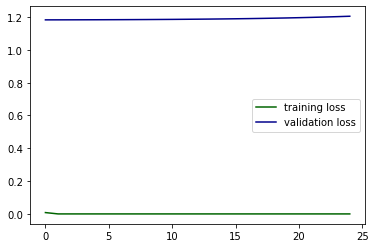

In [137]:
def create_plot(log):
    # plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    # plt.plot(log.history['val_accuracy'], label = "validation accuracy",color='grey')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    plt.show()
    
create_plot(log)

In [130]:
test_loss = model.evaluate(X_test, y_test)
y_test_predict = model.predict(X_test).flatten()
# calculate the roc
roc_score = roc_auc_score(y_test, y_test_predict)
print(f"test_loss: {test_loss}")
print(f"roc: {roc_score}")

36/36 [==============================] - 0s 574us/step - loss: 1.2113
test_loss: 1.2113416194915771
roc: 0.3618838377164002


In [132]:
def calculate_cost(fn,fp):
    return 10*fn+fp

cost_lost = {}
for i in np.linspace(0,0.1,501):
    pred_y = np.where(y_test_predict.flatten()> i, 1, 0)
    cm = confusion_matrix(y_test,pred_y)
    fn,fp = cm[1][0],cm[0][1]
    # cost_lost["Threshold: "+str(i)] = calculate_cost(fn,fp)
    cost_lost[i] = calculate_cost(fn,fp)

optimal_threshold = min(cost_lost, key=cost_lost.get)

Confusion matrix is :
[[1081    0]
 [  56    0]]
Accuracy rate is 0.9507475813544415
Sensitivity is 0.0


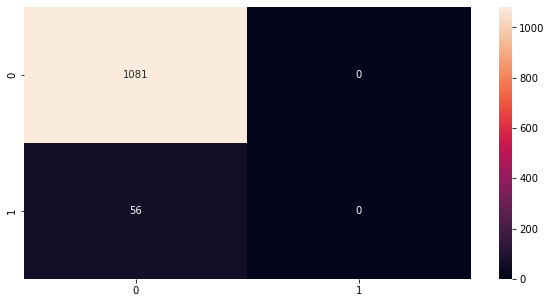

In [133]:
pred_y = np.where(y_test_predict > optimal_threshold, 1, 0)
cm = confusion_matrix(y_test, pred_y)
print(f"Confusion matrix is :" )
print(cm)
accuracy_rate = (cm[0,0] + cm[1,1])/np.sum(cm)
print(f"Accuracy rate is {accuracy_rate}")
# calculate the sensitivity 
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print(f"Sensitivity is {sensitivity}")

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()

# Question 4
### Question
The file "SMOTE.ipynb" explains the process in detail and shows how to change the dataset with an example. You can copy and adjust the code to make it work within your analysis. You can adjust the "sampling_strategy" parameters as you see fit, particularly if
you want to fine-tune your model in part 5.

### Principle
In this part, we are going to try both oversampling and undersampling.


Here is the procedure to process the data
1. Split the raw data into train and test
2. Fit the MinMaxScaler to train data and then apply the model to test data
3. Oversample and undersample the train data
4. Split the train data into train and validation data
5. Show the data distribution before and after oversampling and undersampling

The reason to do so is that we want to make sure that we want to make sure the training data and validation data is similar. And when we test our model, we tend to use real test data instead of the simulated test data.

## 4.1 Split the raw data into train and test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=192,test_size=0.2)

## 4.2 Fit the MinMaxScaler to train data and then apply the model to test data

In [66]:
# Fit the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4.3 Oversample and undersample the train data
We will successively try to oversample the minority class to 10%, 30%, 50% of the size of all datasets.

In [67]:
# Oversampling
# k_neighbors set to 20 to make sure that the result is more general
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state = 483, k_neighbors=20)  
X_over_synth_10, y_over_synth_10 = over.fit_resample(X_train, y_train)
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.5, random_state = 483, k_neighbors=20)
X_over_synth_30, y_over_synth_30 = over.fit_resample(X_train, y_train)
over = imblearn.over_sampling.SMOTE(sampling_strategy=1, random_state = 483, k_neighbors=20)
X_over_synth_50, y_over_synth_50 = over.fit_resample(X_train, y_train)

print("Percentage of 1 in y_over_synth10:", Counter(y_over_synth_10)[1]/len(y_over_synth_10))
print("Percentage of 1 in y_over_synth30:", Counter(y_over_synth_30)[1]/len(y_over_synth_30))
print("Percentage of 1 in y_over_synth50:", Counter(y_over_synth_50)[1]/len(y_over_synth_50))

We will successively try to undersample the minority class to 10%, 30%,50% of the size of majority class.

In [69]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.1, random_state = 483)  
X_under_synth_10, y_under_synth_10 = under.fit_resample(X_train, y_train)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state = 483)
X_under_synth_30, y_under_synth_30 = under.fit_resample(X_train, y_train)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = 483)
X_under_synth_50, y_under_synth_50 = under.fit_resample(X_train, y_train)

print("Percentage of 1 in y_under_synth_10:", Counter(y_under_synth_10)[1]/len(y_under_synth_10))
print("Percentage of 1 in y_under_synth_30:", Counter(y_under_synth_30)[1]/len(y_under_synth_30))
print("Percentage of 1 in y_under_synth_50:", Counter(y_under_synth_50)[1]/len(y_under_synth_50))

Plot to illustrate before (left plot) and after (right plot) undersampling of majority class. Green dots represent the minority class, and Grey dots represent the majority class.

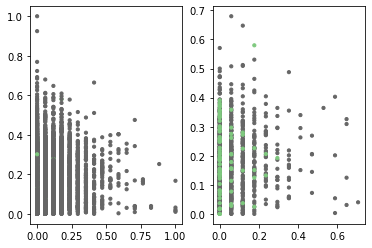

In [72]:
# set plot xticks
x = np.arange(0, len(X_under_synth_10), 1)
plt.xticks(x, x)
plt.subplot(1,2,1)
plt.scatter(X_train[:, 2], X_train[:, 3], c=y_train, s=10, cmap="Accent_r")
plt.subplot(1,2,2)
plt.scatter(X_under_synth_10[:, 2], X_under_synth_10[:, 3], c=y_under_synth_10, s=10, cmap="Accent_r")

## 4.4 Split the train data into train and validation data

In [73]:
X_over_synth_10_train, X_over_synth_10_val, y_over_synth_10_train, y_over_synth_10_val = train_test_split(
    X_over_synth_10, y_over_synth_10, random_state=192, test_size=0.25)
X_over_synth_30_train, X_over_synth_30_val, y_over_synth_30_train, y_over_synth_30_val = train_test_split(
    X_over_synth_30, y_over_synth_30, random_state=192, test_size=0.25)
X_over_synth_50_train, X_over_synth_50_val, y_over_synth_50_train, y_over_synth_50_val = train_test_split(
    X_over_synth_50, y_over_synth_50, random_state=192, test_size=0.25)
X_under_synth_10_train, X_under_synth_10_val, y_under_synth_10_train, y_under_synth_10_val = train_test_split(
    X_under_synth_10, y_under_synth_10, random_state=192, test_size=0.25)
X_under_synth_30_train, X_under_synth_30_val, y_under_synth_30_train, y_under_synth_30_val = train_test_split(
    X_under_synth_30, y_under_synth_30, random_state=192, test_size=0.25)
X_under_synth_50_train, X_under_synth_50_val, y_under_synth_50_train, y_under_synth_50_val = train_test_split(
    X_under_synth_50, y_under_synth_50, random_state=192, test_size=0.25)

print("The length of X_over_synth_10_train is:", len(X_over_synth_10_train))
print("The length of X_over_synth_10_val is:", len(X_over_synth_10_val))
print("The length of X_over_synth_30_train is:", len(X_over_synth_30_train))
print("The length of X_over_synth_30_val is:", len(X_over_synth_30_val))
print("The length of X_over_synth_50_train is:", len(X_over_synth_50_train))
print("The length of X_over_synth_50_val is:", len(X_over_synth_50_val))
print("The length of X_under_synth_10_train is:", len(X_under_synth_10_train))
print("The length of X_under_synth_10_val is:", len(X_under_synth_10_val))
print("The length of X_under_synth_30_train is:", len(X_under_synth_30_train))
print("The length of X_under_synth_30_val is:", len(X_under_synth_30_val))
print("The length of X_under_synth_50_train is:", len(X_under_synth_50_train))
print("The length of X_under_synth_50_val is:", len(X_under_synth_50_val))

# Question 5
### Question
 Create a new (deep) neural network and train it on your enhanced dataset. Use training and validation sets derived from the enhanced dataset to find a model with high accuracy. Evaluate your final model on a test set consisting only of original data. Again, record the accuracy and AUC. Briefly discuss the changes you would expect in the metrics and the actual changes you observe. Would you say that you are now doing better at identifying fraudulent claims?

### Principle
To simplify the problem, and save computational time, we will train the synthetic data to a very simple neural network, and then compare the performance of these dinstinct synthetic data.
After doing this, we are going to select the best performance dataset and then we can use tunner to train the model for it.

The neural network structure is as follows:
1. Input layer
2. 2 Hiiden layers, in which the number of neurons in each layer is equal to 60 and 'relu' function is used
3. No dropout layer
4. Output layer, with 'sigmoid' activation function.
5. Optimizer: AdamOptimizer

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(192)

In [144]:
# Use a controlled model to compare the performance of the different sampling strategies

In [36]:
class TrainModel:
    def __init__(self, X_train, y_train, X_val=None, y_val=None,X_test=None,y_test=None, epochs=100,early_stopping:bool=False,patience:int=10):
        tf.keras.backend.clear_session()
        tf.random.set_seed(192)
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.epochs = epochs
        self.early_stopping= early_stopping
        self.patience = patience
        self.simple_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(60, activation='relu'),
            tf.keras.layers.Dense(60, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def compile(self):
        self.simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def fit(self): # We fit the model with train and validation data becasue validation data can tell us when to stop training
        if self.early_stopping:
            early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=self.patience, restore_best_weights=True) # set patience to 10 to accelerate the training
            self.log = self.simple_model.fit(self.X_train, self.y_train,validation_data= (self.X_val, self.y_val),callbacks=[early_stopping_cb], epochs=self.epochs)
        else:
            self.log = self.simple_model.fit(self.X_train, self.y_train,validation_data= (self.X_val, self.y_val),epochs=self.epochs)

    def evaluate(self): # evalute it on the test dataset, since we are going to predict the raw data like test one
        loss = self.simple_model.evaluate(self.X_test, self.y_test)
        x_test_predict = self.simple_model.predict(self.X_test)
        # calculate the roc
        roc_score = roc_auc_score(self.y_test, x_test_predict)
        # calculate the accuracy suppose the threshold is 0.5
        x_test_predict_binary = np.where(x_test_predict>0.5,1,0)
        accuracy = accuracy_score(self.y_test, x_test_predict_binary)
        # calculate the sensitivity
        sensitivity = recall_score(self.y_test, x_test_predict_binary)
        return {'loss': loss, 'accuracy': accuracy, 'sensitivity': sensitivity, 'roc': roc_score,'modle':self.simple_model}
    
    def draw_the_loss_curve(self):
        # plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
        plt.plot(self.log.history['loss'],label = "training loss",color='darkgreen')
        # plt.plot(log.history['val_accuracy'], label = "validation accuracy",color='grey')
        plt.plot(self.log.history['val_loss'], label = "validation loss",color='darkblue')
        plt.legend()
        plt.show()

    def run(self):
        self.compile()
        self.fit()
        # self.draw_the_loss_curve()
        return self.evaluate()

In this case, if we apply the model to the test data (real data), and select ROC as the metrics to select the sampling strategy, we can find that in the oversampling strategy, the ROC rate is higher than undersampling strategy. Since there is a slight difference between about 10%, 30% and 50% oversampling, we will use the 10% oversampling strategy.

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(192)
res_dict = {} # FIXME
for X_train,y_train,X_val,y_val,name in zip([X_over_synth_10_train,X_over_synth_30_train,X_over_synth_50_train,X_under_synth_10_train,X_under_synth_30_train,X_under_synth_50_train], 
                           [y_over_synth_10_train,y_over_synth_30_train,y_over_synth_50_train,y_under_synth_10_train,y_under_synth_30_train,y_under_synth_50_train],
                           [X_over_synth_10_val,X_over_synth_30_val,X_over_synth_50_val,X_under_synth_10_val,X_under_synth_30_val,X_under_synth_50_val],
                           [y_over_synth_10_val,y_over_synth_30_val,y_over_synth_50_val,y_under_synth_10_val,y_under_synth_30_val,y_under_synth_50_val],
                           ["over_synth_10","over_synth_30","over_synth_50","under_synth_10","under_synth_30","under_synth_50"]):
    tm = TrainModel(X_train,y_train,X_val, y_val, X_test = X_test, y_test =y_test,early_stopping=True)
    res = tm.run()
    res_dict[name] = (res)

2022-03-09 10:17:32.369998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
233/233 [==============================] - 1s 1ms/step - loss: 0.2513 - accuracy: 0.9080 - val_loss: 0.1673 - val_accuracy: 0.9124
Epoch 2/100
233/233 [==============================] - 0s 1ms/step - loss: 0.1440 - accuracy: 0.9346 - val_loss: 0.1103 - val_accuracy: 0.9572
Epoch 3/100
233/233 [==============================] - 0s 991us/step - loss: 0.1059 - accuracy: 0.9555 - val_loss: 0.0908 - val_accuracy: 0.9669
Epoch 4/100
233/233 [==============================] - 0s 973us/step - loss: 0.0817 - accuracy: 0.9684 - val_loss: 0.0703 - val_accuracy: 0.9734
Epoch 5/100
233/233 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9742 - val_loss: 0.0644 - val_accuracy: 0.9754
Epoch 6/100
233/233 [==============================] - 0s 1ms/step - loss: 0.0566 - accuracy: 0.9794 - val_loss: 0.0533 - val_accuracy: 0.9806
Epoch 7/100
233/233 [==============================] - 0s 1ms/step - loss: 0.0501 - accuracy: 0.9817 - val_loss: 0.0455 - val_accuracy: 0.

KeyboardInterrupt: 

In [38]:
for key,value in res_dict.items():
    print(f"{key}:{value['roc']}")

In [97]:
def train_model(hp):
    tf.keras.backend.clear_session()
    tf.random.set_seed(192)
    number_units = hp.Int('number_units', min_value=20, max_value=80, step=20)
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value=0.3) 
    # optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    optim_algo = 'adam'
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 
    number_layers = hp.Int('number_layers', min_value=1, max_value=3) # hidden layers
    activation = hp.Choice('activation', values=['relu','sigmoid'])
    whether_dropout = hp.Choice('whether_dropout', values=[True,False])

    if whether_dropout == True:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(number_units, activation=activation)]*number_layers+[ # number_layers is the number of hidden layers
            tf.keras.layers.Dense(1,activation='sigmoid')])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(number_units, activation=activation)]*number_layers+[ # number_layers is the number of hidden layers
            tf.keras.layers.Dense(1,activation='sigmoid')])

    if optim_algo== 'sgd':
        # Note that exploding gradients can be a big problem when running regressions, especially under SGD
        # Hence, we use "gradient clipping" with parameter alpha, which means that the gradients are manually kept between -1 and 1
        # This is of course another hyperparameter that we might tune!
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=learning_rate, clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate)

    # random_seed = 192
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model


In [58]:
# rm log file
# ! rm -rf ./logs_over_synth_10/

In [98]:
# Run the best model for X_over_synth_10_train
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs_over_synth_10',
                     project_name='kt_tutorial_over_synth_10')
tf.keras.backend.clear_session()
tf.random.set_seed(192)
tuner.search(X_over_synth_10_train, y_over_synth_10_train, epochs=10, validation_data =(X_over_synth_10_val,y_over_synth_10_val))

INFO:tensorflow:Reloading Oracle from existing project logs_over_synth_10\kt_tutorial_over_synth_10\oracle.json
INFO:tensorflow:Reloading Tuner from logs_over_synth_10\kt_tutorial_over_synth_10\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [99]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)

In [100]:
tf.keras.backend.clear_session()
tf.random.set_seed(192)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
log = best_model.fit(X_over_synth_10_train, y_over_synth_10_train, epochs=100, validation_data =(X_over_synth_10_val,y_over_synth_10_val),callbacks=[early_stopping_cb])

Epoch 1/100
233/233 [==============================] - 0s 1ms/step - loss: 0.2027 - val_loss: 0.1349
Epoch 2/100
233/233 [==============================] - 0s 892us/step - loss: 0.1304 - val_loss: 0.1015
Epoch 3/100
233/233 [==============================] - 0s 871us/step - loss: 0.1055 - val_loss: 0.0872
Epoch 4/100
233/233 [==============================] - 0s 836us/step - loss: 0.0843 - val_loss: 0.0733
Epoch 5/100
233/233 [==============================] - 0s 880us/step - loss: 0.0731 - val_loss: 0.0684
Epoch 6/100
233/233 [==============================] - 0s 927us/step - loss: 0.0630 - val_loss: 0.0613
Epoch 7/100
233/233 [==============================] - 0s 880us/step - loss: 0.0590 - val_loss: 0.0509
Epoch 8/100
233/233 [==============================] - 0s 892us/step - loss: 0.0526 - val_loss: 0.0578
Epoch 9/100
233/233 [==============================] - 0s 880us/step - loss: 0.0490 - val_loss: 0.0523
Epoch 10/100
233/233 [==============================] - 0s 875us/step - los

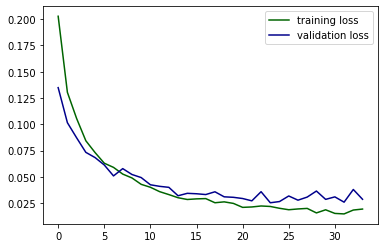

In [101]:
def create_plot(log):
    # plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    # plt.plot(log.history['val_accuracy'], label = "validation accuracy",color='grey')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    plt.show()
create_plot(log)

In [102]:
# save the best model in question 5
# best_model.save('./best_model_question_5.h5')

# load the best model in question 5
best_model=None
best_model = tf.keras.models.load_model('./models/best_model_question_5.h5')

Evaluate the model on the test dataset, and we can find that our ROC score is about 0.82 which is good. In the next part, we are going to select the threshold to predcit the fraud.

In [107]:
loss = best_model.evaluate(X_test, y_test)
y_test_predict = best_model.predict(X_test).flatten()
# calculate the roc
roc_score = roc_auc_score(y_test, y_test_predict)
print(f"test_loss: {loss}")
print(f"roc: {roc_score}")

72/72 [==============================] - 0s 465us/step - loss: 0.4756
test_loss: 0.4756283760070801
roc: 0.7669904572972603


Since it is more costly to miss the fraud cases, and less costly to make a false alarm, we are going to suppose that the cost missed fraud is 10 times more than the cost of false alarm (This ratio can be adjusted to the real case).
Thus, our cost function is:

```Cost = 10*FN + FP```


In [108]:
def calculate_cost(fn,fp):
    return 20*fn+fp

cost_lost = {}
for i in np.linspace(0,0.1,501):
    pred_y = np.where(y_test_predict.flatten()> i, 1, 0)
    cm = confusion_matrix(y_test,pred_y)
    fn,fp = cm[1][0],cm[0][1]
    # cost_lost["Threshold: "+str(i)] = calculate_cost(fn,fp)
    cost_lost[i] = calculate_cost(fn,fp)

optimal_threshold = min(cost_lost, key=cost_lost.get)

Confusion matrix is :
[[2204   45]
 [  23    3]]
Accuracy rate is 0.9701098901098901
Sensitivity is 0.11538461538461539


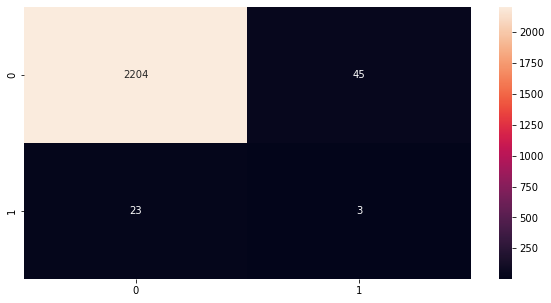

In [115]:
pred_y = np.where(y_test_predict > optimal_threshold, 1, 0)
cm = confusion_matrix(y_test, pred_y)
print(f"Confusion matrix is :" )
print(cm)
accuracy_rate = (cm[0,0] + cm[1,1])/np.sum(cm)
print(f"Accuracy rate is {accuracy_rate}")
# calculate the sensitivity 
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print(f"Sensitivity is {sensitivity}")

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()

# Question 6
### Question
Our second approach will be to use an autoencoder to learn what "normal" (non-fraudulent) data "looks like."

1. Prepare dataset for autoencoder

   - Using the original data, create a training set that contains only non fraudulent claims
   - As well as validation and test sets that contain non fraudulent and fraudulent claims. 
   - Make sure to spread fraudulent claims evenly across validation and test sets.

2. Create an autoencoder using TensorFlow

   - Ensure that the middle hidden layer has fewer neurons than your input features. 
   - Use training and validation sets to find a model that represents its input data well. In particular, you will want to predict your validation set observations. 
   - For each observation, you can measure the difference between the original observations and the predicted one, using, for example, the mean squared error of all features of the observation. 
   - Plot the errors for all your validation set observations in a histogram - in a good model, this error should be much higher for fraudulent claims than non-fraudulent ones.

3. Assess predictions of autoencoder created

   - Use your trained autoencoder to predict the test set and define the corresponding losses(?). 
   - Create a histogram of your test set claims, clearly marking fraudulent and non- fraudulent claims. 
   - Discuss how you could use this to decide whether a transaction is fraudulent or not. 
   - Can you also derive an AUC in this approach - if yes, how does it perform compared to the previous approaches?

In [147]:
# get a copy of raw df

df_autoencoder = df.copy()
# split dataset into non-fraud (normal) and fraud
normal_df = df_autoencoder[df_autoencoder.Fraud == 0]
fraud_df = df_autoencoder[df_autoencoder.Fraud == 1]
print(f'The length of normal_df: {len(normal_df)}')
print(f'The length of fraud_df: {len(fraud_df)}')

# variables for splitting data into train, val and test sets 
train_split = 0.8
test_split = 1 - train_split
normal_train_size = round(len(df_autoencoder) * train_split)
fraud_val_test_size = int(len(fraud_df) / 2)
normal_val_test_size = int(round(len(df_autoencoder) * test_split / 2) - fraud_val_test_size)
print(f'normal_train_size: {normal_train_size}')
print(f'fraud_val_test_size: {fraud_val_test_size}')
print(f'normal_val_test_size: {normal_val_test_size}\n')

# sample non-fraud data for train set
train_df = normal_df.sample(normal_train_size, random_state=0)
normal_df = normal_df[~normal_df.isin(train_df)].dropna()
print(f'len(train_df): {len(train_df)}')
print(f'len(normal_df) excluding data in train_df: {len(normal_df)}\n')

# sample non-fraud data for val and test sets
val_df = normal_df.sample(normal_val_test_size, random_state=0)
test_df = normal_df[~normal_df.isin(val_df)].dropna()
print(f'len(val_df): {len(val_df)}')
print(f'len(test_df): {len(test_df)}\n')

# check if all normal data is in the train, val and test sets
normal_df = df_autoencoder[df_autoencoder.Fraud == 0]
test = pd.concat([train_df, val_df, test_df]).isin(normal_df)
print(f'len(test[test.LossDate == False]) = {len(test[test.LossDate == False])}\n')

# sample fraud data for val and test sets
val_df = val_df.append(fraud_df.sample(fraud_val_test_size, random_state=0))
test_df = test_df.append(fraud_df[~fraud_df.isin(val_df)].dropna())
print(f'len(val_df): {len(val_df)}')
print(f'len(test_df): {len(test_df)}\n')

print(f'Check if len(train_df) + len(val_df) + len(test_df) == len(df_autoencoder): {len(train_df) + len(val_df) + len(test_df) == len(df_autoencoder)}')

The length of normal_df: 11259
The length of fraud_df: 112
normal_train_size: 9097
fraud_val_test_size: 56
normal_val_test_size: 1081

len(train_df): 9097
len(normal_df) excluding data in train_df: 2162

len(val_df): 1081
len(test_df): 1081

len(test[test.LossDate == False]) = 0

len(val_df): 1137
len(test_df): 1137

Check if len(train_df) + len(val_df) + len(test_df) == len(df_autoencoder): True


In [148]:
# Turn the dataframe into numpy arrays
y_train = train_df[['Fraud']].to_numpy()
y_val = val_df[['Fraud']].to_numpy()
y_test = test_df[['Fraud']].to_numpy()

X_train = train_df.drop(['Fraud'], axis=1)
X_val = val_df.drop(['Fraud'], axis=1)
X_test = test_df.drop(['Fraud'], axis=1)

train_col_names = list(X_train.columns)+['df_key']

In [149]:
# Fit the MinMaxScaler
scaler = MinMaxScaler()

X_train.loc[:,'df_key'] = 1
X_val.loc[:,'df_key'] = 0
X_test.loc[:,'df_key'] = 0
X_train_val = pd.concat([X_train, X_val])
# X_df_key = X_train_val[['df_key']]
# X_train_val = X_train_val.drop(['df_key'], axis=1)

X_train_val = pd.DataFrame(scaler.fit_transform(X_train_val), columns=train_col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=train_col_names)
X_test = X_test.drop(['df_key'], axis=1)
X_train = X_train_val[X_train_val.df_key == 1].drop(['df_key'], axis=1)
X_val = X_train_val[X_train_val.df_key == 0].drop(['df_key'], axis=1)

print(f'check if len(X_train) + len(X_val) + len(X_test) == len(df_autoencoder): {len(X_train) + len(X_val) + len(X_test) == len(df_autoencoder)}')
print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"X_test.shape: {X_test.shape}")
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

check if len(X_train) + len(X_val) + len(X_test) == len(df_autoencoder): True
X_train.shape: (9097, 65)
X_val.shape: (1137, 65)
X_test.shape: (1137, 65)


# Question 7

In [150]:
X_train_train,X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [151]:
class AutoEncodingModel:
    def __init__(self, reg_param, number_units_layers, number_units_bottleneck, dropout_rate, number_layers, whether_dropout, whether_regularizer, X_train_train=X_train_train, X_train_val=X_train_val, X_val=X_val,epochs=100) -> None:
        tf.keras.backend.clear_session()
        tf.random.set_seed(192)
        self.X_train_train = X_train_train
        self.X_train_val = X_train_val
        self.X_val = X_val
        self.reg_param = reg_param
        self.number_units_layers = number_units_layers
        self.number_units_bottleneck = number_units_bottleneck
        self.dropout_rate = dropout_rate
        self.number_layers = number_layers
        self.whether_dropout =  whether_dropout
        self.whether_regularizer = whether_regularizer
        self.input_dim = self.X_train_train.shape[1]
        self.epochs  = epochs
        self.build_model()
        self.compile_model()

    def build_model(self):
        """
        Build the model according to the hyperparameters input
        """
        regularizer = tf.keras.regularizers.l2(
            self.reg_param*self.whether_regularizer)
        if self.whether_dropout == True:
            encoder = tf.keras.models.Sequential([
                tf.keras.layers.Dense(self.number_units_layers, activation="relu")]*self.number_layers+[
                tf.keras.layers.Dropout(self.dropout_rate), # dropout before the bottleneck layer
                tf.keras.layers.Dense(self.number_units_bottleneck,activation='sigmoid', kernel_regularizer=regularizer)])
        else:
            encoder = tf.keras.models.Sequential([
                tf.keras.layers.Dense(self.number_units_layers, activation="relu")]*self.number_layers+[
                tf.keras.layers.Dense(self.input_dim,activation='sigmoid')])
        decoder = tf.keras.models.Sequential([
                tf.keras.layers.Dense(self.number_units_layers, activation="relu")]*self.number_layers+[
                tf.keras.layers.Dense(self.input_dim, activation="sigmoid")])
        self.autoencoder = tf.keras.models.Sequential([encoder, decoder])

        # random_seed = 192
    def get_hp(self):
        # get all hyperparameters
        return {
            'reg_param': self.reg_param,
            'number_units_layers': self.number_units_layers,
            'number_units_bottleneck': self.number_units_bottleneck,
            'dropout_rate': self.dropout_rate,
            'number_layers': self.number_layers,
            'whether_dropout': self.whether_dropout,
            'whether_regularizer': self.whether_regularizer
        }

    def get_model(self):
        """
        get the model from the class
        """
        return self.autoencoder

    def compile_model(self):
        """
        compile the model
        """
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.autoencoder.compile(
            optimizer=optimizer, loss='mean_squared_error')

    def __train_model(self):
        """
        Train the data only contains non-fraud claims
        """
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)
        self.log_train_non_fraud = self.autoencoder.fit(x=self.X_train_train, y=self.X_train_train,
                                                        epochs=self.epochs,
                                                        validation_data=(X_train_val, X_train_val), callbacks=[early_stopping_cb])

    def get_train_non_fraud_loss_diff(self):
        """
        calculate the overfit_metric
        """
        self.__train_model()
        return self.log_train_non_fraud.history['val_loss'][-1]-self.log_train_non_fraud.history['loss'][-1] 
        
    def get_train_val_loss(self):
        """
        get the val1_loss
        """
        return self.log_train_non_fraud.history['val_loss'][-1]

    def __apply_model_fraud(self):
        """
        apply the model on the val2, and get the overall average mse loss
        """
        reconstructions = self.autoencoder.predict(self.X_val)
        self.val_loss = np.mean(tf.keras.losses.mse(reconstructions, self.X_val))

    def get_val_loss(self):
        self.__apply_model_fraud()
        return self.val_loss

    def run(self):
        # the difference of loss in the train_train and train_val, the metric to access the overfitting
        overfit_metric = self.get_train_non_fraud_loss_diff()  #TODO change it to overfit_metric
        val2_avg_recon_error = self.get_val_loss() #TODO change it to val2_avg_recon_error
        val1_loss = self.get_train_val_loss()  #TODO change it to val1_loss
        return {"overfit_metric": overfit_metric, "val2_avg_recon_error": val2_avg_recon_error, "val1_loss":val1_loss, "model": self.autoencoder, "log":self.log_train_non_fraud}


Generate a list of hyperparameters and train the model. After trainnig the model, we will record the hyperparameters and the performance of the model.

In [153]:
tf.keras.backend.clear_session()
tf.random.set_seed(192)
round = 30
model_list = [] # list of to save model
class_list = []
log_list = []
para_dfm = pd.DataFrame(columns=['reg_param', 'number_units_layers', 'number_units_bottleneck', 'dropout_rate', 'number_layers', 'whether_dropout', 'whether_regularizer','overfit_metric', 'val1_loss','val2_avg_recon_error'])
for i in range(round):
    print(f"This round is {i}")
    # generate a list of hyperparameters
    reg_param = np.random.uniform(low=0.1, high=0.3)
    numbers_units_layers = np.random.choice(np.arange(30, 61, 15))
    numbers_units_bottleneck = np.random.choice(np.arange(5, 16, 5))
    dropout_rate = np.random.uniform(low=0.01, high=0.05)
    numbers_layers = np.random.choice(np.arange(1, 4, 1))
    whether_dropout = np.random.choice([True, False])
    whether_regularizer = np.random.choice([True, False])
    autoencoder = AutoEncodingModel(reg_param, numbers_units_layers, numbers_units_bottleneck, dropout_rate, numbers_layers, whether_dropout, whether_regularizer)
    
    # get the result of the model
    res = autoencoder.run()
    overfit_metric  = res['overfit_metric']
    val2_avg_recon_error = res['val2_avg_recon_error']
    model = res['model']
    val1_loss = res['val1_loss']

    # fill the value into the dataframe
    para_dfm = para_dfm.append({"reg_param": reg_param, "number_units_layers": numbers_units_layers, "number_units_bottleneck": numbers_units_bottleneck, "dropout_rate": dropout_rate, "number_layers": numbers_layers, "whether_dropout": whether_dropout, "whether_regularizer": whether_regularizer, "overfit_metric": overfit_metric, "val2_avg_recon_error": val2_avg_recon_error,'val1_loss':val1_loss}, ignore_index=True)
    
    # add model into model_list
    model_list.append(model)

    # add initalized class into class_list
    class_list.append(autoencoder)

    # add log into log_list
    log_list.append(res['log'])

This round is 0
Epoch 1/100
199/199 [==============================] - 1s 1ms/step - loss: 0.0857 - val_loss: 0.0432
Epoch 2/100
199/199 [==============================] - 0s 1ms/step - loss: 0.0374 - val_loss: 0.0330
Epoch 3/100
199/199 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0256
Epoch 4/100
199/199 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0195
Epoch 5/100
199/199 [==============================] - 0s 1ms/step - loss: 0.0175 - val_loss: 0.0159
Epoch 6/100
199/199 [==============================] - 0s 970us/step - loss: 0.0148 - val_loss: 0.0136
Epoch 7/100
199/199 [==============================] - 0s 960us/step - loss: 0.0128 - val_loss: 0.0121
Epoch 8/100
199/199 [==============================] - 0s 985us/step - loss: 0.0116 - val_loss: 0.0111
Epoch 9/100
199/199 [==============================] - 0s 955us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 10/100
199/199 [==============================] - 0s 970us/st

In [161]:
# para_dfm.to_csv("para_dfm.csv")
para_dfm = pd.read_csv("para_dfm.csv", index_col=0)

In [165]:
# calculate the model score according to the val2_avg_recon_error and overfit_metric
para_dfm["model_score"] = para_dfm["val2_avg_recon_error"] - para_dfm["overfit_metric"] 
para_dfm = para_dfm.sort_values(by=["model_score"], ascending=False)
para_dfm.head()

,reg_param,number_units_layers,number_units_bottleneck,dropout_rate,number_layers,whether_dropout,whether_regularizer,overfit_metric,val1_loss,val2_avg_recon_error,model_score
14,0.157531,45,10,0.042284,3,True,True,-0.000208,0.035214,0.035545,0.035753
10,0.296043,60,5,0.038431,2,True,True,-0.000193,0.035076,0.035325,0.035518
11,0.278233,30,15,0.026990,3,True,True,-0.000091,0.034352,0.033971,0.034062
9,0.140251,30,10,0.048218,2,True,True,-0.000063,0.032355,0.032074,0.032137
7,0.121099,30,15,0.010889,2,True,True,-0.000208,0.029198,0.028471,0.028678


Go through all the models we have trained and look into the relationship of the model_score and the performance of model.
In the table, we are going to record the model_score, the sensitivity(select the mean of reconstruction_error as threshold), accuracy_rate and AUC.

In [168]:
# df_performance_diff_sens.to_csv("df_performance_diff_sens.csv")
df_performance_diff_sens = pd.read_csv("df_performance_diff_sens.csv", index_col=0)

In [166]:
# NOTE: read "df_performance_diff_sens" from local file

# df_performance_diff_sens = pd.DataFrame(columns=['model_score', 'sensitivity','accuracy_rate','roc'])
# for ind, row in para_dfm.iterrows():
#     print(f"The model_score is: {row['model_score']}")
#     model_pred = model_list[ind]
#     X_pred = model_pred.predict(X_val)
#     mse = np.mean(np.power(X_val.flatten() - X_pred.flatten(), 2))
#     reconstructions = model_pred.predict(X_val)
#     val_loss = tf.keras.losses.mae(reconstructions, X_val)
#     # sns.histplot(x=val_loss,y=y_val.flatten(),hue=y_val.flatten())
#     # plt.show()
#     df_tmp = pd.DataFrame({"val_loss": val_loss, "y_val": y_val.flatten()})
#     df_tmp_fraud = df_tmp[df_tmp["y_val"] == 1]
#     df_tmp_non_fraud = df_tmp[df_tmp["y_val"] == 0]
#     mse = np.mean(np.power(X_val.flatten() - X_pred.flatten(), 2))
#     error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_val.flatten()})
#     df_temp = pd.DataFrame({'Reconstruction_error': val_loss, 'True_class': y_val.flatten()})
#     roc = roc_auc_score(y_val.flatten(), val_loss)
#     threshold = np.mean(df_temp["Reconstruction_error"])
#     pred_y = np.where(val_loss > threshold, 1, 0)
#     cm = confusion_matrix(y_val.flatten(), pred_y)
#     accuracy_rate = (cm[0,0] + cm[1,1])/np.sum(cm)
#     # calculate the sensitivity 
#     sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
#     print(f"sensitivity is: {sensitivity}")
#     df_performance_diff_sens = df_performance_diff_sens.append({"model_score": row['model_score'], "sensitivity": sensitivity,'accuracy_rate':accuracy_rate,'roc':roc}, ignore_index=True)

# df_performance_diff_sens

The model_score is: 0.0357533716658366
sensitivity is: 0.9107142857142857
The model_score is: 0.035517538613419004
sensitivity is: 0.8928571428571429
The model_score is: 0.034062358267150955
sensitivity is: 0.875
The model_score is: 0.03213658117274097
sensitivity is: 0.75
The model_score is: 0.0286783649607514
sensitivity is: 0.8035714285714286
The model_score is: 0.0280588391213848
sensitivity is: 0.8392857142857143
The model_score is: 0.009594675678234299
sensitivity is: 0.6785714285714286
The model_score is: 0.006373727335124
sensitivity is: 0.6071428571428571
The model_score is: 0.005692174136747119
sensitivity is: 0.6428571428571429
The model_score is: 0.0047340097452514
sensitivity is: 0.5357142857142857
The model_score is: 0.003951114842308001
sensitivity is: 0.5
The model_score is: 0.0039336294798794
sensitivity is: 0.5178571428571429
The model_score is: 0.0018317777850155
sensitivity is: 0.5
The model_score is: 0.0018006495684629998
sensitivity is: 0.5178571428571429
The mode

,model_score,sensitivity,accuracy_rate,roc
0,0.035753,0.910714,0.566403,0.767015
1,0.035518,0.892857,0.565523,0.766800
2,0.034062,0.875000,0.576077,0.761943
3,0.032137,0.750000,0.605981,0.724544
4,0.028678,0.803571,0.587511,0.721802
5,0.028059,0.839286,0.560246,0.729781
6,0.009595,0.678571,0.637643,0.697783
7,0.006374,0.607143,0.660510,0.697932
8,0.005692,0.642857,0.653474,0.678555
9,0.004734,0.535714,0.669305,0.689887


We are going to explore the distubution of the fraud cases in the test set of each model. Usually, the higher the model score, the fraud cases are more likely to be concentrated at a large number.

The model_score is: 0.0357533716658366


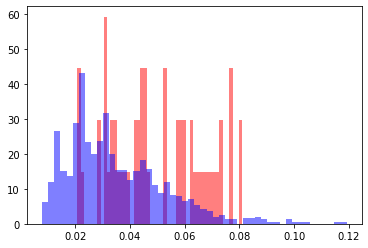

The model_score is: 0.035517538613419004


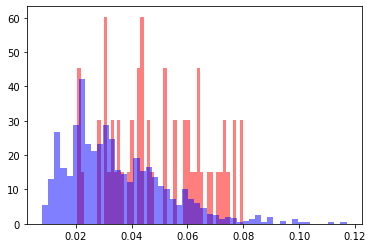

The model_score is: 0.034062358267150955


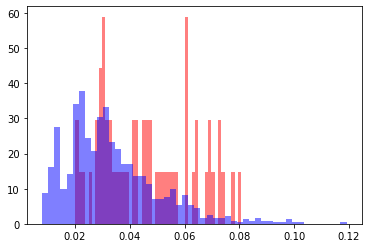

The model_score is: 0.03213658117274097


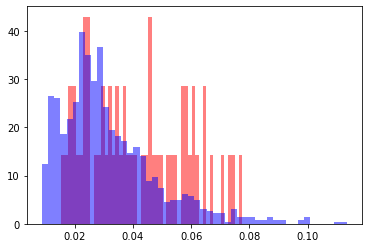

The model_score is: 0.0286783649607514


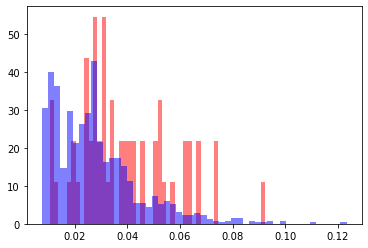

The model_score is: 0.0280588391213848


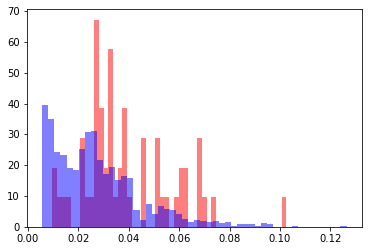

The model_score is: 0.009594675678234299


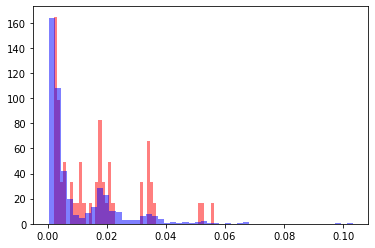

The model_score is: 0.006373727335124


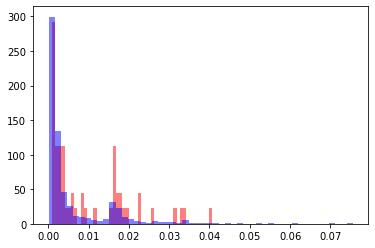

The model_score is: 0.005692174136747119


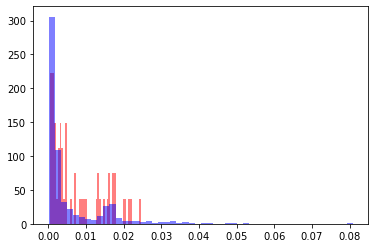

The model_score is: 0.0047340097452514


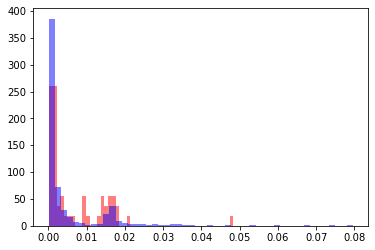

The model_score is: 0.003951114842308001


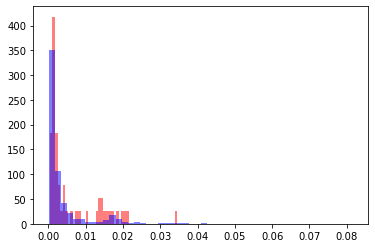

The model_score is: 0.0039336294798794


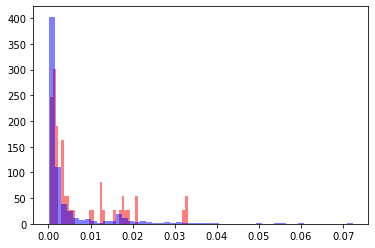

The model_score is: 0.0018317777850155


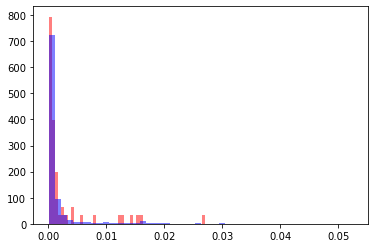

The model_score is: 0.0018006495684629998


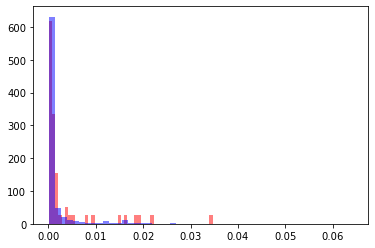

The model_score is: 0.000640171852732


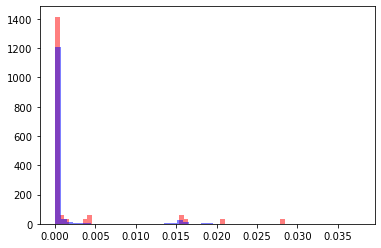

The model_score is: 0.000640171852732


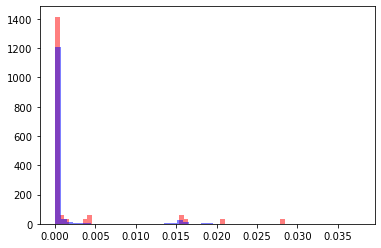

The model_score is: 0.000640171852732


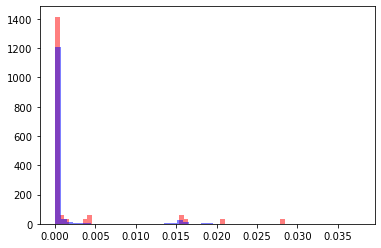

The model_score is: 0.000640171852732


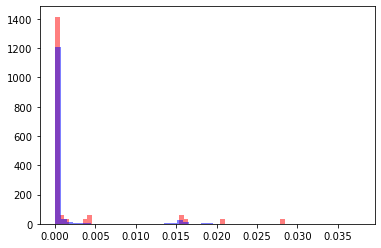

The model_score is: 0.000640171852732


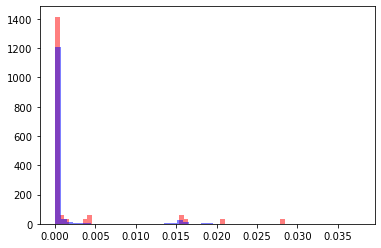

The model_score is: 0.000640171852732


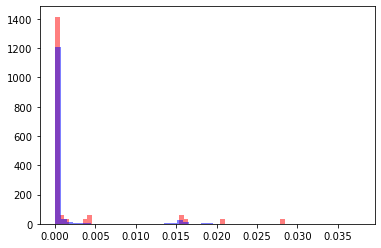

The model_score is: 0.000640171852732


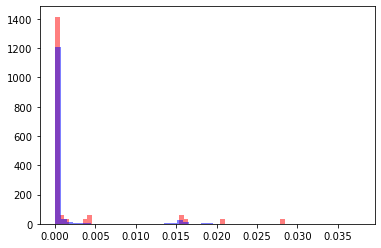

The model_score is: 0.00046207577897270003


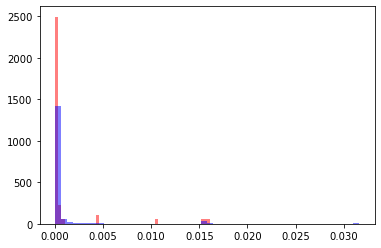

The model_score is: 0.00046207577897270003


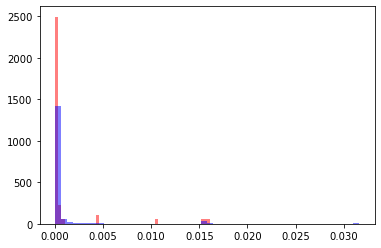

The model_score is: 0.00046207577897270003


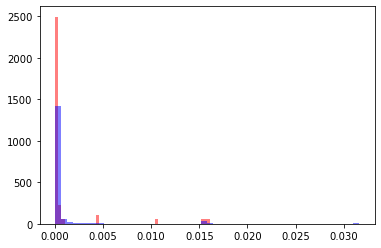

The model_score is: 0.00046207577897270003


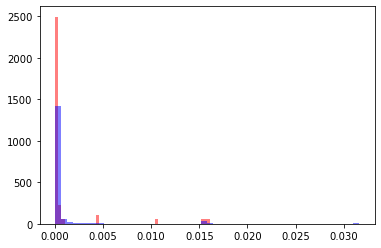

The model_score is: 2.8306897405700013e-05


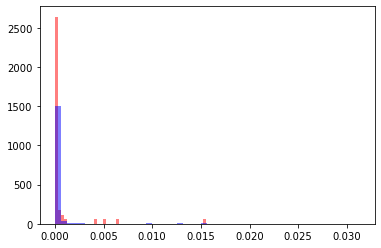

The model_score is: 2.8306897405700013e-05


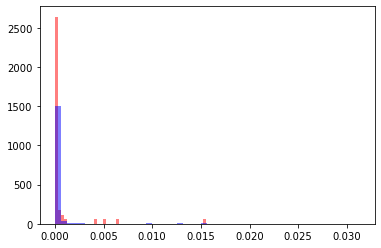

The model_score is: 2.8306897405700013e-05


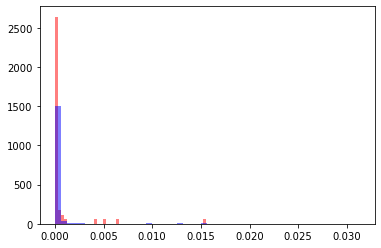

The model_score is: 2.8306897405700013e-05


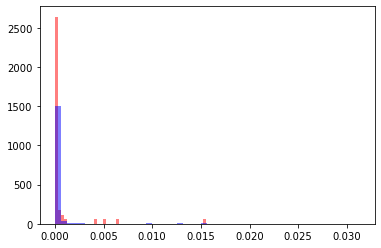

The model_score is: 2.8306897405700013e-05


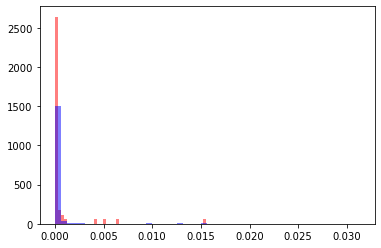

In [167]:
for ind, row in para_dfm.iterrows():
    print(f"The model_score is: {row['model_score']}")
    model_pred = model_list[ind]
    X_pred = model_pred.predict(X_val)
    mse = np.mean(np.power(X_val.flatten() - X_pred.flatten(), 2))
    reconstructions = model_pred.predict(X_val)
    val_loss = tf.keras.losses.mse(reconstructions, X_val)
    df_tmp = pd.DataFrame({"val_loss": val_loss, "y_val": y_val.flatten()})
    df_tmp_fraud = df_tmp[df_tmp["y_val"] == 1]
    df_tmp_non_fraud = df_tmp[df_tmp["y_val"] == 0]
    plt.hist(df_tmp_fraud["val_loss"], bins=50, alpha=0.5, label="fraud", color="red",density=True)
    plt.hist(df_tmp_non_fraud["val_loss"], bins=50, alpha=0.5, label="non_fraud", color="blue",density=True)
    plt.show()

Show the relationship between model_score and other columns, we can find a very significant linear relationship between these columns.

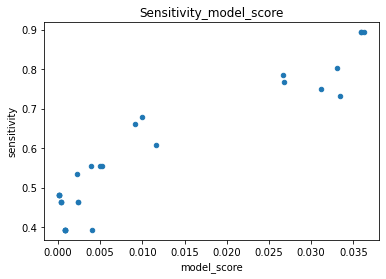

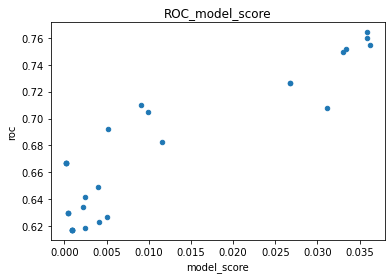

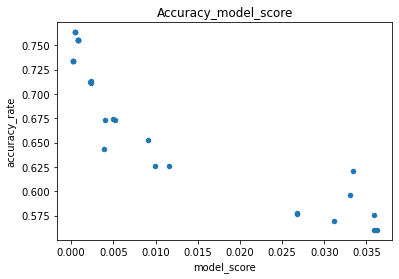

In [35]:
df_performance_diff_sens.plot(x='model_score', y='sensitivity', kind='scatter',title='Sensitivity_model_score')
plt.show()
df_performance_diff_sens.plot(x='model_score', y='roc', kind='scatter',title='ROC_model_score')
plt.show()
df_performance_diff_sens.plot(x='model_score', y='accuracy_rate', kind='scatter',title='Accuracy_model_score')
plt.show()

We are going to use statsmodel to test whether it is significant. We can find the p-value of the model is very low, which means the model is significant.

In [36]:
# linear regression #TODO more linear regression test

X  = np.array(df_performance_diff_sens['model_score'], dtype=float)
y = np.array(df_performance_diff_sens['sensitivity'], dtype=float)
X = sm.add_constant(X)
print("Statsmodels linear regression betwen model_score and sensitivity")
model = sm.OLS(y, X).fit()
print(model.summary())

X = np.array(df_performance_diff_sens['model_score'], dtype=float)
y = np.array(df_performance_diff_sens['accuracy_rate'], dtype=float)
X = sm.add_constant(X)
print("Statsmodels linear regression betwen model_score and accuracy_rate")
model = sm.OLS(y, X).fit()
print(model.summary())
print('-------------------------------------------------------')

X = np.array(df_performance_diff_sens['model_score'], dtype=float)
y = np.array(df_performance_diff_sens['roc'], dtype=float)
X = sm.add_constant(X)
print("Statsmodels linear regression betwen model_score and roc")
model = sm.OLS(y, X).fit()
print(model.summary())
print('-------------------------------------------------------')


Statsmodels linear regression betwen model_score and sensitivity
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     220.8
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           8.27e-15
Time:                        11:59:09   Log-Likelihood:                 44.392
No. Observations:                  30   AIC:                            -84.78
Df Residuals:                      28   BIC:                            -81.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

# Question 8
Based on the results of the previous question, we can use the model_score to select the best model.

In [120]:
# get the index of largest model_score row
para_dfm_max_index = para_dfm[para_dfm["model_score"]==max(para_dfm["model_score"])].index[0]
# get the loss function of the best model
def create_plot(log,limit=None):
    if limit:
    # plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
        plt.plot(log.history['loss'][-limit:],label = "training loss",color='darkgreen')
        # plt.plot(log.history['val_accuracy'], label = "validation accuracy",color='grey')
        plt.plot(log.history['val_loss'][-limit:], label = "validation loss",color='darkblue')
        plt.legend()
        plt.show()
    else:
        plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
        plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
        plt.legend()
        plt.show()

create_plot(log_list[para_dfm_max_index])

NameError: name 'para_dfm' is not defined

In [42]:
# get the index of largest model_score row
autoencoder_best = model_list[int(para_dfm_max_index)]
# autoencoder_best.save('./models/autoencoder_best.h5') # save the best model

We are going to reset the weight and train the model again.

In [117]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.

    This is a fast approximation of re-initializing the weights of a model.

    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).

    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)
    return model


Epoch 1/200
285/285 [==============================] - 1s 1ms/step - loss: 0.0655 - val_loss: 0.0471
Epoch 2/200
285/285 [==============================] - 0s 970us/step - loss: 0.0450 - val_loss: 0.0423
Epoch 3/200
285/285 [==============================] - 0s 909us/step - loss: 0.0324 - val_loss: 0.0274
Epoch 4/200
285/285 [==============================] - 0s 897us/step - loss: 0.0272 - val_loss: 0.0264
Epoch 5/200
285/285 [==============================] - 0s 923us/step - loss: 0.0260 - val_loss: 0.0247
Epoch 6/200
285/285 [==============================] - 0s 891us/step - loss: 0.0250 - val_loss: 0.0237
Epoch 7/200
285/285 [==============================] - 0s 951us/step - loss: 0.0242 - val_loss: 0.0235
Epoch 8/200
285/285 [==============================] - 0s 956us/step - loss: 0.0235 - val_loss: 0.0224
Epoch 9/200
285/285 [==============================] - 0s 936us/step - loss: 0.0229 - val_loss: 0.0224
Epoch 10/200
285/285 [==============================] - 0s 931us/step - los

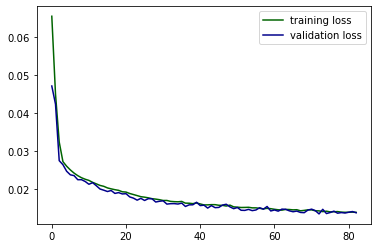

In [125]:
tf.keras.backend.clear_session()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# reset the all the weight of autoencoder model
autoencoder_best = shuffle_weights(autoencoder_best)
log = autoencoder_best.fit(x=X_train, y=X_train, epochs=200, validation_data=(X_val, X_val), callbacks=[early_stopping_cb])

create_plot(log)

ROC:  0.7108697793538219


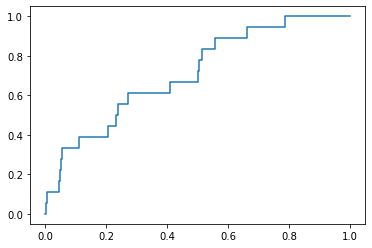

In [116]:
# autoencoder_best.save('models/autoencoder_best.h5')
autoencoder_best = tf.keras.models.load_model('./models/autoencoder_best.h5')
X_pred = autoencoder_best.predict(X_val)
mse = np.mean(np.power(X_val.flatten() - X_pred.flatten(), 2))
reconstructions = autoencoder_best.predict(X_val)
val_loss = tf.keras.losses.mae(reconstructions, X_val)
# sns.histplot(x=val_loss,y=y_val.flatten(),hue=y_val.flatten())
# plt.show()
df_tmp = pd.DataFrame({"val_loss": val_loss, "y_val": y_val.flatten()})
df_tmp_fraud = df_tmp[df_tmp["y_val"] == 1]
df_tmp_non_fraud = df_tmp[df_tmp["y_val"] == 0]
mse = np.mean(np.power(X_val.flatten() - X_pred.flatten(), 2))
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_val.flatten()})
df_temp = pd.DataFrame({'Reconstruction_error': val_loss, 'True_class': y_val.flatten()})
roc = roc_auc_score(y_val.flatten(), val_loss)
print("ROC: ", roc)
#plot the roc curve
fpr, tpr, thresholds = roc_curve(y_val.flatten(), val_loss)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)

## Set the threshold for fraud
We are going to use three method to set the threshold for fraud:
1. Use the mean of the reconstruction error plus one standard deviation as the threshold
2. Set the threshold to the minimum of the reconstruction error of fraud cases
3. Set the threshold to the minimize the cost function we mentioned above, which is 10*FN + FP

If it is real case, we would recommend to use the third method. Because it can have company to lower the cost.


## Method 1
Use the mean of the reconstruction error plus one standard deviation as the threshold

In [117]:
# select the threshold with test dataset
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold: ", threshold)

Threshold:  0.13694909581231235


In [118]:
# pred y based on the threshold
test_loss = autoencoder_best.predict(X_test)
reconstructions = autoencoder_best.predict(X_val)
test_loss = tf.keras.losses.mae(reconstructions, X_val)
pred_y = np.where(test_loss > threshold, 1, 0)
cm = confusion_matrix(y_test.flatten().astype(int), pred_y)
print(f"Confusion matrix is :" )
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()
accuracy_rate = (cm[0,0] + cm[1,1])/np.sum(cm)
print(f"Accuracy rate is {accuracy_rate}")
# calculate the sensitivity 
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print(f"Sensitivity is {sensitivity}")

ValueError: Found input variables with inconsistent numbers of samples: [2275, 2274]

## Method 2
Set the threshold to the minimum of the reconstruction error of fraud cases

<AxesSubplot:>

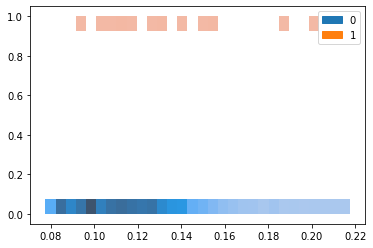

In [119]:
# show the distribution of the model_score

sns.histplot(x=val_loss,y=y_val.flatten(),hue=y_val.flatten())

In [80]:
# select the threshold with test dataset
df_temp = pd.DataFrame({'Reconstruction_error': val_loss, 'True_class': y_val.flatten()})
df_temp_fraud = df_temp[df_temp['True_class']==1]
threshold = df_temp_fraud["Reconstruction_error"].min()
print("Threshold: ", threshold)

Threshold:  0.0711917878068816


Confusion matrix is :
Accuracy rate is 0.4098504837291117
Sensitivity is 0.9821428571428571


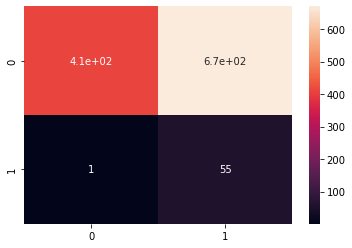

In [81]:
# pred y based on the threshold
pred_y = np.where(test_loss > threshold, 1, 0)
cm = confusion_matrix(y_test.flatten().astype(int), pred_y)
print(f"Confusion matrix is :" )
sns.heatmap(cm, annot=True)
accuracy_rate = (cm[0,0] + cm[1,1])/np.sum(cm)
print(f"Accuracy rate is {accuracy_rate}")
# calculate the sensitivity 
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print(f"Sensitivity is {sensitivity}")

## Method 3
Set the threshold to the minimize the cost function we mentioned above, which is 10*FN + FP

In [82]:
# select the threshold with test dataset
#  the cost function
def calculate_cost(fn,fp):
    return 100*fn+fp

cost_lost = {}
for i in np.linspace(0,0.1,100):
    pred_y = np.where(val_loss > i, 1, 0)
    cm = confusion_matrix(y_val.flatten(), pred_y)
    fn,fp = cm[1][0],cm[0][1]
    # cost_lost["Threshold: "+str(i)] = calculate_cost(fn,fp)
    cost_lost[i] = calculate_cost(fn,fp)

threshold = min(cost_lost, key=cost_lost.get)
print("Threshold: ", threshold)

Threshold:  0.0707070707070707


Confusion matrix is :
Accuracy rate is 0.405452946350044
Sensitivity is 1.0


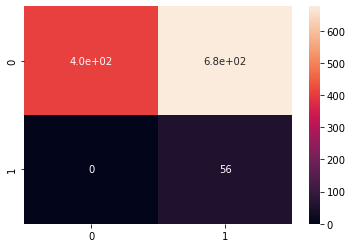

In [83]:
# pred y based on the threshold
pred_y = np.where(test_loss > threshold, 1, 0)
cm = confusion_matrix(y_test.flatten().astype(int), pred_y)
print(f"Confusion matrix is :" )
sns.heatmap(cm, annot=True)
accuracy_rate = (cm[0,0] + cm[1,1])/np.sum(cm)
print(f"Accuracy rate is {accuracy_rate}")
# calculate the sensitivity 
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print(f"Sensitivity is {sensitivity}")

# Question 9

### Question
As you know, it is difficult to understand precisely why a neural network makes a specific prediction. Discuss why this might be problematic when the neural network prediction leads to a fraud investigation by the insurance company. What alternatives can you envision that make use of the techniques we have applied and allow for more interpretability and transparency?

### Answer
The issue with neural network predictions in a fraud investigation is its “black box” behaviour: its internal logic in achieving the classification results is often hard to be interpreted or explained to both users and observers. If a customer is wrongly investigated for fraud by the company, they would generally demand an understanding of why they were investigated. Due to its complex intricacies, neural networks fail to explain why a claim is fraudulent despite its potentially high accuracy.

Solutions to neural network anomaly detection can be recommended in two ways. Firstly the model can be improved and refined to continuously perform better after each iterative improvement. Secondly, alternative machine learning classifications can replace the neural networks to provide greater context to the decision to investigate a customer for potential fraud. Regarding the first point, several alternative neural network classification models can be suggested particularly for anomaly detection. Al’Dahoul et al., 2021 created a novel neural network strategy that “combines binary normal/attack DNN to detect the availability of any attack and multi-attacks DNN to categorize the attacks” (Al’Dahoul et al., 2021:16). This anomaly detection and classification model outperformed the baseline solution and reduced the ‘false alarm rate’ for the highly imbalanced dataset. Additionally, Long Short-Term Memory (LSTM) neural networks can be implemented to find complex relationships in multivariate time series data. This system looks at the previous timeframe and predicts the behavior for the next. If the actual value a minute later is within one standard deviation then there is no problem. Other novel classification solutions include DAICS, which is more robust to the additive noise (Abdelaty et al., 2020), GT, which eliminates the need for autoencoders and improves results (Golan & Yaniv, 2018), and E3 outlier, which uses inlier priority for unsupervised outlier detection  (Wang et al., 2019). These solutions are more accurate, and improve results such as ROC values of the models. 


There are alternative machine learning classification models that can both make use of the techniques we have applied, and also allow a much better interpretability and transparency. Decision trees, for example, can explain the features that are used to segment a claim to fraud and non-fraud, while random forests can be used to show the importance of each feature in classifying the claims. This is a better improvement for transparency, as the features can highlight the information that can potentially be linked to fraudulent behaviours. Furthermore, both random forests and decision trees can be tuned for the right hyperparameters in order to optimise the model. Decision trees can be pruned, while random forest can have hyperparameters, such as maximum number of depths, number of trees and the minimum number of samples per leaf, be fully optimised. Additionally, random forests can provide a different interpretation of a decision tree but with better performance. Considering we need to understand which combination of variables flagged a customer for investigation, a decision tree can help understand how each variable is contributing to the prediction model, despite providing a reduction in the model performance. 



# Question 10

Trained enhanced dataset on logistic regression, decision tree and random forest
How does your model perform compared to the previous models you have developed? 
Compare accuracy and AUC score
Should we expect our simple models to perform better than the neural network? - to be filled later when we get the score
Does your model allow you to answer a customer who asks, “why am I being investigated”?
Yes - random forest can explain
<show feature examples>
E.g. claims that has x number of years, with this feature and this feature are classified as fraudulent. These features are heavily linked with behaviours that are associated with frauds.

After training logistic regression, decision tree and random forest on our enhanced model, we found the following AUC and accuracy score for our models:

Logistic Regression
Accuracy = 97.0%
AUC Score = 85.7%

Decision Tree
Accuracy = 97.5%
AUC Score = 73.2%

Random Forest
Accuracy = 98.8%
AUC Score = 85.4%

We obtained favourable AUC scores when the dataset is balanced

<compare score to neural networks>

The tree-based classification models can help explain why claims are being marked as fraudulent. For example, a feature “ClaimWithoutIdentifiedThirdParty” is considered as one of the significant features that distinguish a claim into fraudulent, acting as one of the main features to split a sample to ‘Fraud’ and ‘Not Fraud’. This feature can be rationalised, where fraud claims are more likely to not have a third party. Furthermore, Random Forest models can also calculate the importance of each variable when determining the classification. This can highlight which features are significant in deciding the binary class.


# References
References:

Abdelaty, M. F., Doriguzzi Corin, R., & Siracusa, D. (2021;2020;). DAICS: A deep learning solution for anomaly detection in industrial control systems. IEEE Transactions on Emerging Topics in Computing, , 1-1. https://doi.org/10.1109/TETC.2021.3073017

AlDahoul, N., Abdul Karim, H., & Ba Wazir, A. S. (2021). Model fusion of deep neural networks for anomaly detection. Journal of Big Data, 8(1), 1-18. https://doi.org/10.1186/s40537-021-00496-w

Blanque, P. (2003). Crisis and fraud. Journal of Financial Regulation and Compliance, 11(1), 60-70. https://doi.org/10.1108/13581980310810417

Chakravarty, S., Demirhan, H., & Baser, F. (2020). Fuzzy regression functions with a noise cluster and the impact of outliers on mainstream machine learning methods in the regression setting. Applied Soft Computing, 96, 106535. https://doi.org/10.1016/j.asoc.2020.106535

Golan, I., & El-Yaniv, R. (2018). Deep anomaly detection using geometric transformations.
Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

Reed, R., & Marks, R. J. (1999). Neural smithing: Supervised learning in feedforward artificial neural networks. MIT Press. https://doi.org/10.7551/mitpress/4937.001.0001
